In [788]:
import json
import os
import sys
import importlib
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import ttest_1samp, wilcoxon
import statannot

from statsmodels.stats.multitest import fdrcorrection, multipletests

plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

In [179]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
class_abbrevs = json.load(open('../data/metadata/molec_class_abbrev.json'))

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

# Connected dots plot

## Group data within-animal and sampling

## Take RSD of each 3-week repeated measurement for each metabolite within each animal within each sampling type

## find mean of these RSDs for connected dot plot

In [162]:
rbgs = [f'RBGweek{x}' for x in range(8, 13)]
fbgs = [f'FBGweek{x}' for x in range(8, 13)]

bgs = ap.loc[ap['original'], rbgs + fbgs]
bgs['animal'] = bgs.index
bgs['Nile rat label'] = bgs['animal'].map(ap['Nile rat label'])
bgs['rmean'] = bgs[rbgs].mean(axis=1)
bgs['fmean'] = bgs[fbgs].mean(axis=1)
bgs['rrsd'] = (bgs[rbgs].std(axis=1) / bgs['rmean']) * 100
bgs['frsd'] = (bgs[fbgs].std(axis=1) / bgs['fmean']) * 100
bgs = bgs.sort_values('Nile rat label')

mbgs = bgs.melt(id_vars=['animal', 'Nile rat label', 'rmean', 'fmean'], 
                value_vars=rbgs+fbgs, value_name='BG', var_name='week')
mbgs['bg_type'] = mbgs['week'].str[:3]
mbgs['week'] = mbgs['week'].str[7:].astype('int')
mbgs['rdiff'] = mbgs['BG'] - mbgs['rmean']
mbgs['fdiff'] = mbgs['BG'] - mbgs['fmean']
mbgs['r%'] = mbgs['rdiff'] / mbgs['BG'] * 100
mbgs['f%'] = mbgs['fdiff'] / mbgs['BG'] * 100
mbgs = mbgs.sort_values('Nile rat label')
mbgs = mbgs.loc[~(mbgs['f%'] < -100) | ~(mbgs['r%'] < -100)]

label_order = [x for x in 'ABCDEFGHIJ']
animal_order = mbgs['animal'].unique()
rdf = mbgs.loc[(mbgs['bg_type'] == 'RBG') & (mbgs['r%'] > -100), ['r%', 'animal', 'week', 'Nile rat label']]
fdf = mbgs.loc[(mbgs['bg_type'] == 'FBG') & (mbgs['f%'] > -100), ['f%', 'animal', 'week', 'Nile rat label']]

In [833]:
gb = np.power(2, data.loc[:, data_cols])
gb = gb.drop(['1091_8_FBG', '1091_10_FBG'], axis=1) 
gb = (gb
 .T
 .join(fg[['animal', 'bg_type']])
 .groupby(['animal', 'bg_type'])
)
gb = (gb.std() / gb.mean()) * 100
display(gb)

per_animal = (gb
    .median(axis=1)
    .reset_index()
    )
per_animal['bg_type'] = per_animal['bg_type'].map({'RBG': 'Non-fasted', 'FBG': 'Fasted'})
per_animal = per_animal.rename({0: '% RSD'}, axis=1)
per_animal['animal'] = per_animal['animal'].astype('int')
per_animal['Nile rat label'] = per_animal['animal'].map(ap['Nile rat label'])
per_animal = per_animal.sort_values('Nile rat label')
loc_dict = {x: i for x, i in zip('ABCDEFGHIJ', range(10))}
per_animal['loc'] = per_animal['Nile rat label'].map(loc_dict)
display(per_animal)

superclass_type_dict = dict(zip(data['superclass'], data['Type']))
per_class = (gb
            .groupby(data['molec_class'], axis=1)
            .median()
            .groupby(level=['bg_type'])
            .median()
            .melt(ignore_index=False, value_name='% RSD')
            .reset_index()
            .assign(superclass=lambda x: x['molec_class'].map(compound_superclasses))
            .assign(Type=lambda x: x['superclass'].map(superclass_type_dict))
            .sort_values(['Type', '% RSD', 'bg_type'], ascending=[True, True, False])
            )
# display(per_class)
per_class = per_class.loc[per_class['molec_class'] != 'Unidentified']
per_class['bg_type'] = per_class['bg_type'].map({'RBG': 'Non-fasted', 'FBG': 'Fasted'})
loc_dict = {x: i for x, i in zip(per_class['molec_class'].unique(), range(len(per_class['molec_class'].unique())))}
per_class['loc'] = per_class['molec_class'].map(loc_dict)
display(per_class)

violin_data = gb.melt(var_name='i', ignore_index=False).reset_index()
violin_data['Nile rat label'] = violin_data['animal'].map(ap['Nile rat label'])
violin_data['bg_type'] = violin_data['bg_type'].map({'RBG': 'Non-fasted', 'FBG': 'Fasted'})
violin_data = violin_data.sort_values('Nile rat label')
violin_data = violin_data.join(data['molec_class'], on='i')
display(violin_data)

ddf = pd.read_excel('../data/metadata/12hour RBGs.xlsx', index_col=0)
ddf.index = [x[1:] for x in ddf.index]
ddf['animal'] = ddf.index
time_order = ddf.filter(regex='^\d').columns
ddf['median'] = ddf[time_order].median(axis=1)
ddf['mean'] = ddf[time_order].mean(axis=1)
ddf['mean_rank'] = ddf['mean'].rank()
ddf['% RSD'] = ddf[time_order].std(axis=1)/ddf['mean'] * 100
mddf = ddf.melt(id_vars=['sex', 'animal', 'mean', 'mean_rank'], value_vars=time_order, value_name='RBG', var_name='Time')
# mddf.index = mddf['animal']
mddf['mean_diff'] = mddf['RBG'] - mddf['mean']
mddf['mean_%_diff'] = mddf['mean_diff'] / mddf['mean'] * 100
display(ddf)
display(mddf)
rbg_order = ddf.sort_values('mean').index
sex_order = ddf.sort_values(['sex', 'mean']).index

# Remove the x location difference from metabolite classes: 
per_class.loc[per_class['Type'] == 'metabolite', 'loc'] -= 15

m_0        m_1        m_2        m_3         m_4  \
animal bg_type                                                            
1060   FBG      135.033146  11.724372  38.015422   9.518486  171.980900   
       RBG      109.122505  27.174735  80.128477  13.155240   88.240480   
1062   FBG       42.979048  27.955164  62.624951  30.996139  160.287064   
       RBG       19.083103  24.371803  52.503763  12.482614   23.810329   
1074   FBG       41.796211  49.819737  40.514368   9.226702  133.628845   
       RBG       49.853000  18.802471  24.756410  33.676962   16.997728   
1076   FBG       42.521250  39.558616  75.738414  29.379181  157.000903   
       RBG       92.719056   7.771533  58.085292  19.890841  107.344687   
1082   FBG       53.819767  13.035534  23.361274  18.722329   88.575586   
       RBG       72.632782  12.717651  21.561572  11.503434   90.954593   
1091   RBG       41.892354  21.031027  29.466034  22.278570   77.824078   
1092   FBG       34.177809  14.478312  35.117777  10.121304  101.793867   
       RBG       23.623592  11.054094  12.752727  29.271496  101.279148   
1093   FBG       53.464270  17.880001  44.250662   8.394440   22.613023   
       RBG       39.026897  11.652806  38.806249  28.857759   51.435289   
1101   FBG       35.251797  18.784187  28.128477  17.021727   88.760300   
       RBG       38.021394   6.547001  32.433858  10.397039   68.806258   
1102   FBG       61.058866  14.404511  41.061658  14.555573  114.041335   
       RBG       70.763276  11.945092  78.894882   2.147696  104.513330   

                      m_5        m_6        m_7        m_8        m_9  ...  \
animal bg_type                                                         ...   
1060   FBG      20.668780  16.601535  15.573181  20.589889   8.088724  ...   
       RBG      12.514570  12.742306  25.169451  11.635403   7.380230  ...   
1062   FBG      27.082323  10.321457   7.961478  15.700581  27.218032  ...   
       RBG      22.673909   3.903375  20.813806   6.872019   8.850415  ...   
1074   FBG       8.430682  15.635192  56.206303  17.458921  32.239555  ...   
       RBG      23.611413  21.558153  10.817154  16.923088   5.885145  ...   
1076   FBG      66.918022  43.569026  51.807949  45.716528  46.971014  ...   
       RBG       7.201984   6.275901  14.192407   9.498442   6.511294  ...   
1082   FBG      18.334695  36.413534  17.034660  35.561428   6.837246  ...   
       RBG      17.183937  18.556488  13.846643  17.162169  23.161192  ...   
1091   RBG       2.106939  12.743451   5.944904  13.310693   9.148420  ...   
1092   FBG      13.261534  24.046540  13.658066  27.386919   7.298736  ...   
       RBG      30.385349  28.730235  31.744977  29.720533  24.070132  ...   
1093   FBG       4.130082   8.411879  11.617008  11.438302  16.488283  ...   
       RBG      13.126940  14.579750   4.443541  15.681928  10.127275  ...   
1101   FBG      30.739933  46.565770  35.547258  42.313600  16.411968  ...   
       RBG       8.991498   4.670655  21.596673   4.683508   7.621106  ...   
1102   FBG      10.581403  11.901872  19.190857  17.154349   5.827639  ...   
       RBG      11.838497   3.067916  17.539519   4.276553  13.453786  ...   

                    l_907      l_908       l_909       l_910       l_911  \
animal bg_type                                                             
1060   FBG      53.913007  62.266682   70.789872   81.354452   60.843040   
       RBG      14.531870  23.072559   17.708002   36.556058   17.215803   
1062   FBG      57.768430  40.506285   45.445081   68.452936   49.886002   
       RBG      29.641263  43.362206   46.959111   38.064287   42.031696   
1074   FBG      54.442843  50.806159   49.873126  114.926248   59.028862   
       RBG      17.060906  18.902980   30.443218   13.545431   16.917963   
1076   FBG      66.948414  62.466418   57.651575   63.426389   54.609026   
       RBG      33.627248  31.121593   29.858626   27.850837   35.908943   
1082   FBG      97.588290  72.624082  128.961679

,animal,bg_type,% RSD,Nile rat label,loc
10,1091,Non-fasted,27.730305,A,0
14,1093,Non-fasted,23.947800,B,1
13,1093,Fasted,20.359515,B,1
12,1092,Non-fasted,25.302882,C,2
11,1092,Fasted,21.187946,C,2
4,1074,Fasted,28.095956,D,3
5,1074,Non-fasted,21.367378,D,3
2,1062,Fasted,26.863007,E,4
3,1062,Non-fasted,20.490741,E,4
18,1102,Non-fasted,19.105944,F,5


,bg_type,molec_class,% RSD,superclass,Type,loc
0,Fasted,AC,14.140623,Fatty Acyl,lipid,0
38,Fasted,SM,15.331435,Sphingolipid,lipid,1
1,Non-fasted,AC,15.838062,Fatty Acyl,lipid,0
8,Fasted,CE,16.141940,Sterol Lipid,lipid,2
29,Non-fasted,PI,16.294640,Phospholipid,lipid,3
39,Non-fasted,SM,16.425895,Sphingolipid,lipid,1
33,Non-fasted,Plasmanyl-PE,16.915532,Phospholipid,lipid,4
25,Non-fasted,PC,17.212549,Phospholipid,lipid,5
37,Non-fasted,Plasmenyl-PE,17.224428,Phospholipid,lipid,6
31,Non-fasted,Plasmanyl-PC,17.345243,Phospholipid,lipid,7


,animal,bg_type,i,value,Nile rat label,molec_class
0,1060,Fasted,m_0,135.033146,NaN,Unidentified
1,1060,Non-fasted,m_0,109.122505,NaN,Unidentified
2,1062,Fasted,m_0,42.979048,NaN,Unidentified
3,1062,Non-fasted,m_0,19.083103,NaN,Unidentified
4,1074,Fasted,m_0,41.796211,NaN,Unidentified
...,...,...,...,...,...,...
26766,1093,Non-fasted,l_916,38.184628,NaN,Unidentified
26767,1101,Fasted,l_916,43.266060,NaN,Unidentified
26768,1101,Non-fasted,l_916,34.610618,NaN,Unidentified
26769,1102,Fasted,l_916,32.240494,NaN,Unidentified


,sex,10am,11am,12pm,1pm,2pm,3pm,4pm,5pm,6pm,...,8pm,9pm,10pm,weight 10am,weight 10pm,animal,median,mean,mean_rank,% RSD
1772F,F,296.666667,290.000000,350.5,281.500000,288.500000,351.5,295.500000,350.5,253.5,...,252.5,268.333333,218.500000,111.6,110.2,1772F,288.500000,291.153846,12.0,13.867024
1771F,F,258.500000,192.500000,210.0,178.000000,171.000000,148.5,154.000000,201.0,213.5,...,243.0,193.333333,216.000000,127.9,127.8,1771F,201.000000,203.141026,4.0,17.782218
1767M,M,291.666667,252.000000,155.0,145.000000,165.000000,184.0,258.000000,229.0,248.5,...,220.5,220.500000,226.000000,122.6,120.5,1767M,226.000000,217.551282,5.0,20.034393
1735M,M,338.500000,242.500000,277.0,263.000000,284.500000,307.5,292.000000,260.5,272.5,...,257.0,288.000000,281.500000,124.0,122.8,1735M,277.000000,278.769231,11.0,8.955611
1748F,F,93.000000,80.000000,110.0,156.000000,99.000000,103.0,78.500000,116.5,95.0,...,75.0,99.500000,82.000000,125.8,126.0,1748F,99.000000,101.076923,1.0,22.289428
1792M,M,302.500000,296.500000,367.5,311.500000,312.500000,335.0,276.000000,291.0,306.0,...,269.0,308.500000,327.500000,130.5,120.5,1792M,306.000000,306.230769,13.0,8.727893
1768M,M,334.000000,230.000000,270.0,264.000000,286.500000,244.0,177.000000,210.0,288.0,...,223.5,246.500000,197.500000,129.2,128.2,1768M,244.000000,246.807692,7.0,17.065372
1757M,M,254.000000,262.000000,243.5,266.333333,253.000000,237.5,263.000000,275.0,278.0,...,278.0,361.000000,361.333333,127.7,125.2,1757M,266.333333,277.128205,10.0,14.185483
1680M,M,357.500000,257.000000,251.0,227.000000,211.666667,235.5,207.000000,270.5,253.0,...,276.5,209.000000,248.000000,120.5,120.9,1680M,248.000000,246.935897,8.0,16.635832
1669F,F,214.000000,128.666667,224.0,193.500000,227.500000,231.0,179.666667,162.5,156.5,...,193.0,241.500000,171.500000,122.2,121.4,1669F,193.000000,192.333333,3.0,17.555058


,sex,animal,mean,mean_rank,Time,RBG,mean_diff,mean_%_diff
0,F,1772F,291.153846,12.0,10am,296.666667,5.512821,1.893439
1,F,1771F,203.141026,4.0,10am,258.500000,55.358974,27.251499
2,M,1767M,217.551282,5.0,10am,291.666667,74.115385,34.068006
3,M,1735M,278.769231,11.0,10am,338.500000,59.730769,21.426600
4,F,1748F,101.076923,1.0,10am,93.000000,-8.076923,-7.990868
...,...,...,...,...,...,...,...,...
164,M,1680M,246.935897,8.0,10pm,248.000000,1.064103,0.430923
165,F,1669F,192.333333,3.0,10pm,171.500000,-20.833333,-10.831889
166,M,1666M,250.576923,9.0,10pm,235.500000,-15.076923,-6.016884
167,F,1664F,109.134615,2.0,10pm,103.000000,-6.134615,-5.621145


# Perform paired t-test on all of the groups to determine significance of fasted vs fed difference

- A paired t-test is the same as doing a 1-sample t-test on the difference in RSDs between each metabolite in fasted and fed
    - 1-sample t-test checks whether your distribution has a mean different than a certain value (here, value=0)
    
### Because of the low N for some molecule classes (e.g. CE has N=4), it is not indicated to do a t-test, use wilcoxon instead 
#### This is especially true for Figure 3A where we group within Nile rat and therefore have even lower N

Ttest_1sampResult(statistic=-9.514503521682938, pvalue=7.603292790862778e-21)
Ttest_1sampResult(statistic=-6.714593537309924, pvalue=2.727595034338542e-11)


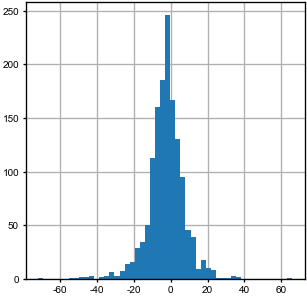

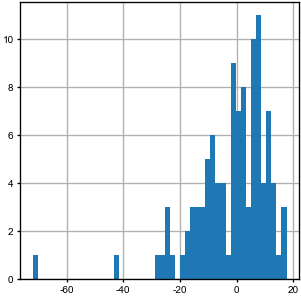

In [293]:
bg_means = gb.groupby(level='bg_type').mean()
bg_mean_diff = bg_means.loc['RBG'] - bg_means.loc['FBG']

bg_medians = gb.groupby(level='bg_type').median()
bg_median_diff = bg_medians.loc['RBG'] - bg_medians.loc['FBG']

bg_mean_diff.hist(bins=50)
plt.gcf().set_size_inches(3, 3)

print(ttest_1samp(bg_mean_diff, 0))
print(ttest_1samp(bg_median_diff, 0))

lipid_idx = data.loc[data['molec_class'] == 'TG'].index
lipid_diff = bg_diff[lipid_idx]
plt.figure()
lipid_diff.hist(bins=50)
plt.gcf().set_size_inches(3, 3)

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


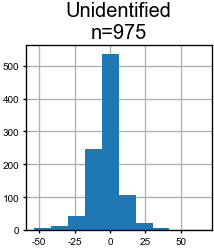

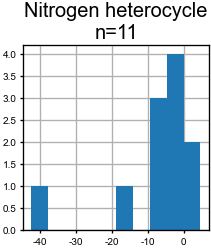

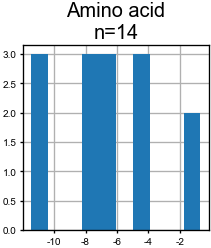

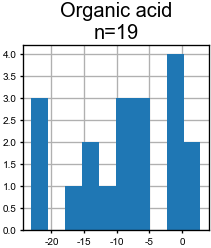

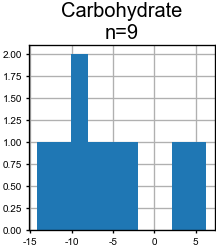

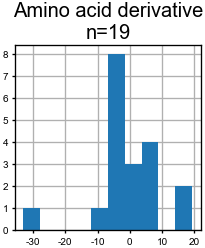

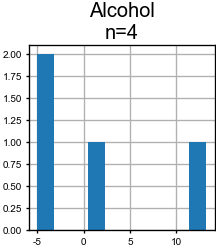

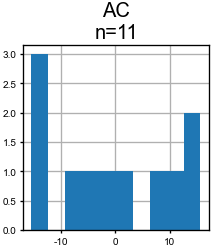

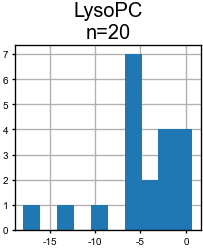

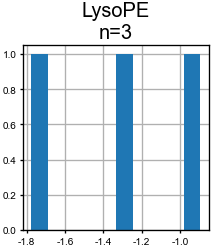

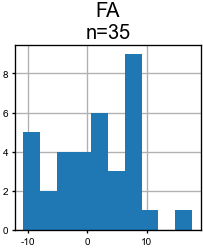

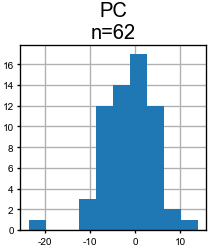

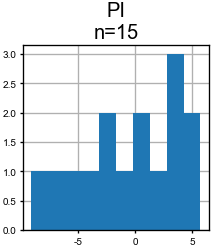

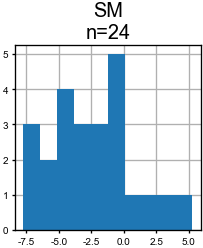

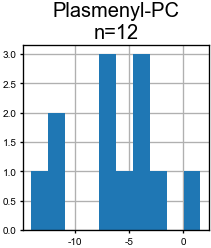

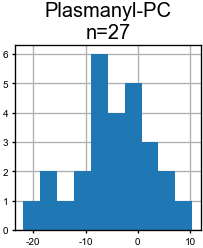

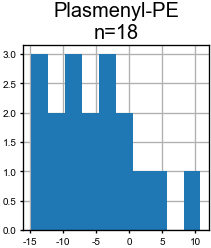

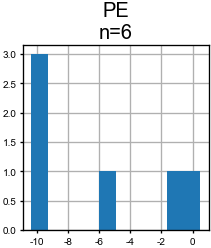

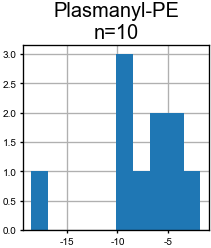

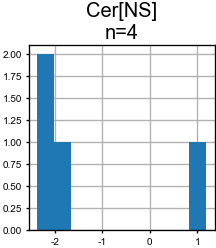

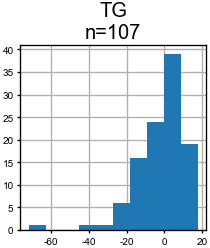

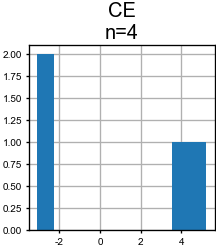

In [285]:
for cls in data['molec_class'].unique():
    idxs = data.loc[data['molec_class'] == cls].index
    plt.figure()
    plt.title(cls + '\nn=' + str(len(idxs)))
    bg_mean_diff[idxs].hist(bins=10)
    plt.gcf().set_size_inches(2, 2)

## Within-Nile rat t-test

array([8.49884415e-001, 5.96759941e-009, 1.77828613e-021, 8.67937491e-124,
       1.00000000e+000, 1.02909052e-019, 2.02581097e-016, 5.99905677e-014,
       2.10331361e-001])

In [816]:
ratdiff = gb.drop('1091', level='animal').groupby(level='animal').diff()
ratdiff = ratdiff.xs('RBG', level='bg_type')
ratdiff

rat_results = {}
for animal in ratdiff.index:
    rat_results[animal] = wilcoxon(ratdiff.loc[animal]).pvalue
rat_results = pd.Series(rat_results).to_frame('wilcoxon')

# Bonferroni 
rat_results['qval_wilcoxon'] = multipletests(rat_results['wilcoxon'], method='bonferroni')[1]

rat_results['qval_signif'] = rat_results['qval_wilcoxon'] < 0.05
rat_results['qval_asterisk'] = rat_results['qval_wilcoxon'].apply(src.utils.parse_p_value)
rat_results['animal label'] = rat_results.index.astype('int').map(ap['Nile rat label'])
rat_results = rat_results.sort_values('animal label')
rat_results['x_pos'] = range(1, 10)
rat_results

,wilcoxon,qval_wilcoxon,qval_signif,qval_asterisk,animal label,x_pos
1093,2.250901e-17,2.025811e-16,True,****,B,1
1092,1.143434e-20,1.029091e-19,True,****,C,2
1074,1.975873e-22,1.778286e-21,True,****,D,3
1062,6.630666e-10,5.967599e-09,True,****,E,4
1102,2.337015e-02,2.103314e-01,False,ns,F,5
1060,9.443160e-02,8.498844e-01,False,ns,G,6
1101,6.665619e-15,5.999057e-14,True,****,H,7
1082,3.062383e-01,1.000000e+00,False,ns,I,8
1076,9.643750e-125,8.679375e-124,True,****,J,9


In [815]:
# all_together = multipletests(mc_results['wilcoxon_mean'].to_list() + 
#                              rat_results['wilcoxon'].to_list(), method='bonferroni')
# pd.Series(all_together[1], 
#           index=[mc_results['wilcoxon_mean'].index.to_list() + 
#                  rat_results['wilcoxon'].index.to_list()])

## T-test for All nile rats fasted vs fed RSD
### the q-value is clearly **** 4 asterisks

In [799]:
all_rats_diff = gb.drop('1091', level='animal').groupby(level='bg_type').mean().diff().iloc[1]
wilcoxon(all_rats_diff)

WilcoxonResult(statistic=314504.0, pvalue=8.745519962487533e-33)

## Within-molecule class t-test

In [819]:
unique_id_classes = data.loc[data['molec_class'] != 'Unidentified', 'molec_class'].unique()

classes = [(data.loc[data['molec_class'] == mc].index, mc, data.loc[data['molec_class'] == mc, 'Type'].iloc[0]) 
           for mc in unique_id_classes]

results = {}

for indexes, name, Type in [
    (data.index, 'all', 'summary'),
                      
    (data.loc[data['Type'] == 'lipid'].index, 'all lipids', 'summary'),
    (data.loc[data['Type'] == 'metabolite'].index, 'all metabs', 'summary'),
    
    (data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified')].index, 'all id lipids', 'summary'),
    (data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified')].index, 'all id metabs', 'summary'),
    *classes
                     ]:
    result = {}
    for df, diff_type in ([bg_mean_diff, 'mean'], [bg_median_diff, 'median']):
        for ttest, ttest_name in [(ttest_1samp, 'ttest_1samp'),  (wilcoxon, 'wilcoxon')]:
            test_df = df[indexes]
            result[f'{ttest_name}_{diff_type}'] = ttest(test_df, (0 if ttest_name == 'ttest_1samp' else None)).pvalue
            results[name] = result
    
    result['Type'] = Type
    result['n'] = len(indexes)
    result['lower RSD sampling type'] = ('Fasted' if bg_median_diff.loc[indexes].median() > 0 else 'Fed')
mc_results = pd.DataFrame(results).T
# display(mc_results.loc[(mc_results > 0.05).any(axis=1)])

mc_results['qval_wilcoxon'] = multipletests(mc_results['wilcoxon_mean'], method='bonferroni')[1]

mc_results['qval_signif'] = mc_results['qval_wilcoxon'] < 0.05
mc_results['qval_asterisk'] = mc_results['qval_wilcoxon'].apply(src.utils.parse_p_value)
mc_results['class_abbrev'] = mc_results.index.map(class_abbrevs)
mc_results.loc[mc_results['Type'] != 'summary', 'loc'] = mc_results.loc[mc_results['Type'] != 'summary'].index.map(
    lambda mc: per_class.loc[per_class['molec_class'] == mc, 'loc'].iloc[0])
mc_results

,ttest_1samp_mean,wilcoxon_mean,ttest_1samp_median,wilcoxon_median,Type,n,lower RSD sampling type,qval_wilcoxon,qval_signif,qval_asterisk,class_abbrev,loc
all,0.0,0.0,0.0,0.0,summary,1409,Fed,0.0,True,****,NaN,NaN
all lipids,0.000154,0.000018,0.036446,0.048662,summary,914,Fed,0.000464,True,***,NaN,NaN
all metabs,0.0,0.0,0.0,0.0,summary,495,Fed,0.0,True,****,NaN,NaN
all id lipids,0.000002,0.000005,0.000261,0.00135,summary,358,Fed,0.000117,True,***,NaN,NaN
all id metabs,0.000004,0.000001,0.000792,0.000333,summary,76,Fed,0.000021,True,****,NaN,NaN
Nitrogen heterocycle,0.091609,0.041992,0.074617,0.083008,metabolite,11,Fed,1,False,ns,Nhc,4.0
Amino acid,0.000007,0.000122,0.001495,0.003052,metabolite,14,Fed,0.003174,True,**,AA,0.0
Organic acid,0.000125,0.000095,0.008913,0.008232,metabolite,19,Fed,0.00248,True,**,OA,1.0
Carbohydrate,0.036311,0.039062,0.107882,0.164062,metabolite,9,Fed,1,False,ns,Carb.,2.0
Amino acid derivative,0.729789,0.828785,0.52445,0.890568,metabolite,19,Fasted,1,False,ns,AAD,5.0


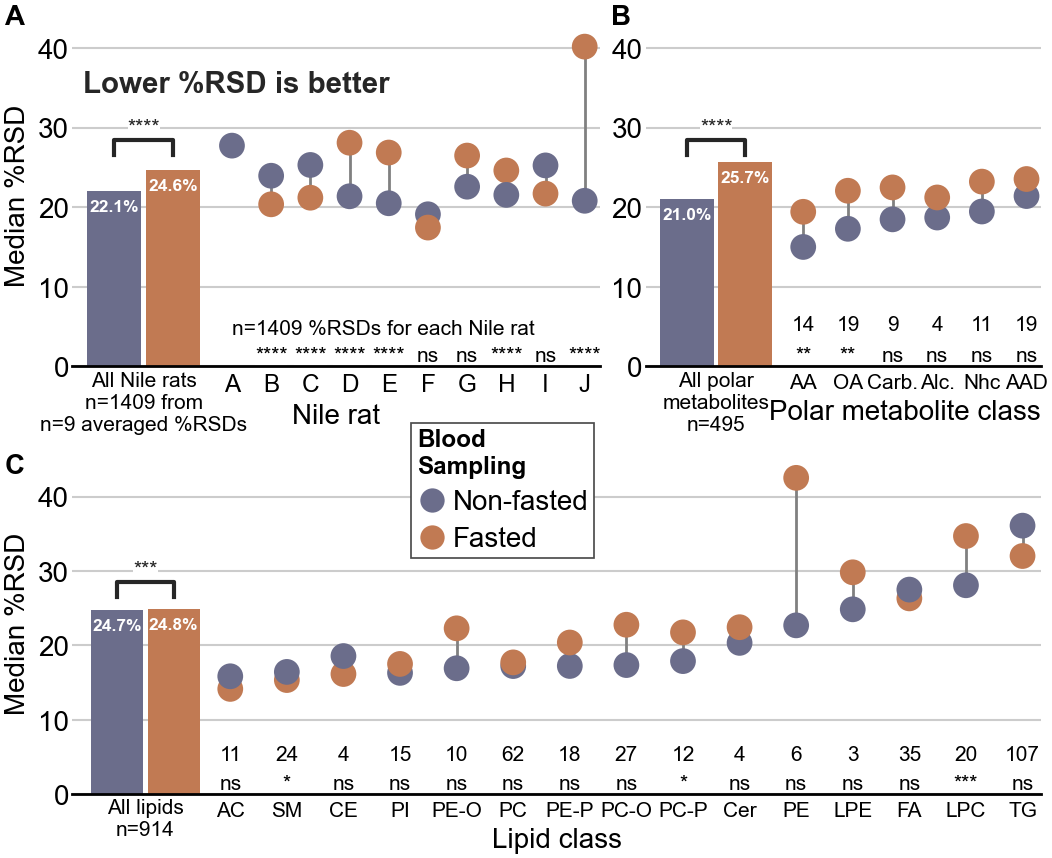

In [827]:
importlib.reload(src.plots)
pccopy = per_class.copy()
pcm = pccopy.loc[pccopy['Type'] == 'metabolite']
pcl = pccopy.loc[pccopy['Type'] == 'lipid']
gm = acdf.groupby(['Type', 'Blood sampling']).median()

fig, axs = plt.subplot_mosaic(
    """
    NM
    LL
    """,
    figsize=(5, 4), dpi=250, sharey=False, gridspec_kw=dict(width_ratios=(1, 0.75), wspace=0.1, hspace=0.25))
axn, axm, axl = axs['N'], axs['M'], axs['L']
axs = axs.values()
hue_order = ['Fasted', 'Non-fasted', ]
s = 55
sns.scatterplot(
    data=per_animal, x='Nile rat label', y='% RSD', ax=axn,
    hue='bg_type', hue_order=hue_order, palette=colors, 
    linewidth=0, edgecolors='none', zorder=2, s=s, legend=False)
sns.scatterplot(
    data=pcm, x='molec_class', y='% RSD', ax=axm,
    hue='bg_type', hue_order=hue_order, palette=colors, 
    linewidth=0, edgecolors='none', legend=False, zorder=2, s=s)
sns.scatterplot(
    data=pcl, x='molec_class', y='% RSD', ax=axl,
    hue='bg_type', hue_order=hue_order, palette=colors, 
    linewidth=0, edgecolors='none', legend=False, zorder=2, s=s)
# Plot group median bars and text
for group, ax, df, multiplier in [('Nile rat',   axn,  per_animal, 1.5), 
                                  ('metabolite', axm,  pcm,        1.3),
                                  ('lipid',      axl,  pcl,        1.0),]: 
    fed_height, fasted_height = [gm.loc[(group, 'Fed'), '% RSD'], 
                                 gm.loc[(group, 'Fasted'), '% RSD']]
    x_pos = np.array([-2*multiplier, -1*multiplier])
    ax.bar(x=x_pos, 
           height=[fed_height, fasted_height], 
           color=[colors['Fed'], colors['Fasted']], width=0.92*multiplier)
    ax.text(x_pos[0], fed_height-1, str((round(fed_height, 1))) + '%', 
            fontsize=5, color='white', fontweight='bold', ha='center', va='top', )
    ax.text(x_pos[1], fasted_height-1, str((round(fasted_height, 1))) + '%', 
            fontsize=5, color='white', fontweight='bold', ha='center', va='top', )
    
    if group   == 'Nile rat':   
        group_n = "1409 from\nn=9 averaged %RSDs"
        group_text = 'All Nile rats'
        group_qval_asterisk = '****'
    elif group == 'metabolite': 
        group_text = 'All polar\nmetabolites'
        group_n = mc_results.loc['all metabs', 'n']
        group_qval_asterisk = '****'
    elif group == 'lipid':      
        group_text = 'All lipids'
        group_n = mc_results.loc['all lipids', 'n']
        group_qval_asterisk = '***'
    ax.text(x_pos.mean(), -0.6, f'{group_text}\nn={group_n}', 
            va='top', ha='center', fontsize=6)
    src.plots.custom_pval(group_qval_asterisk, x_pos[0], x_pos[1], 26.5, 2, ax=ax, bbox=dict(lw=0, fc='white', pad=0))
    
    for loc in df['loc'].unique():
        # plot gray lines connecting the scatter points
        sdf = df.loc[df['loc'] == loc]
        try: 
            nonfasted_rsd = sdf.loc[sdf['bg_type'] == 'Non-fasted', '% RSD'].values[0]
            fasted_rsd    = sdf.loc[sdf['bg_type'] == 'Fasted', '% RSD'].values[0]
            ax.plot([loc, loc], [fasted_rsd, nonfasted_rsd], color='gray', lw=0.8, zorder=1,)
        except IndexError:
            pass    
        # plot significance 
axn.set_xlabel('Nile rat')
axm.set_xlabel('Polar metabolite class', loc='right')
axl.set_xlabel('Lipid class')
axn.set_ylabel('Median %RSD')
axm.set_ylabel(None)
axl.set_ylabel('Median %RSD')
axn.set_yticks([0, 10, 20, 30, 40])
axm.set_yticks([0, 10, 20, 30, 40])
axl.set_yticks([0, 10, 20, 30, 40])
metab_classes = pd.Series(pcm.sort_values('loc')['molec_class'].unique())
metab_classes = metab_classes.map(class_abbrevs)
axm.set_xticks(ticks=range(len(metab_classes)), labels=metab_classes)
lipid_classes = pd.Series(pcl.sort_values('loc')['molec_class'].unique())
lipid_classes = lipid_classes.map(class_abbrevs)
axl.set_xticks(ticks=range(len(lipid_classes)), labels=lipid_classes)
axn.set_ylim(0, 43)
axm.set_ylim(axn.get_ylim())
axl.set_ylim(0, 46)
for ax in axs:
    ax.tick_params(axis='x', length=0, pad=2, labelsize=7)
    ax.tick_params(axis='y', length=0, pad=1, labelsize=8)
    ax.grid(axis='y', color=src.plots.GRID_LIGHT_COLOR, lw=src.plots.GRID_LW)
    ax.set_axisbelow(True)
for ax in [axm, axl]:
    ax.tick_params(axis='x', rotation=0, labelsize=6)
axn.margins(0.03)
axm.margins(0.04)
axl.margins(0.02)
legend = src.plots.custom_legend(
    entries=['Non-fasted', 'Fasted'], ax=axl, loc=(0.35, 0.69),
    sort=False, title='Blood\nSampling',
    mew=0, ms=7, 
    show_frame=True, frame_color='1', frame_edgecolor='0.3', frame_edgewidth=0.5,
    handlelength=1.1, handletextpad=0.2)

for ax, letter in zip(axs, ['A', 'B', 'C']):
    bb = src.plots.tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1 - (0.05 if letter == 'C' else 0), s=letter, 
            fontsize=src.plots.LABEL_FONTSIZE + 1, transform=fig.transFigure, fontweight='bold')
group_metadata_fontsize = 6
# Add ns, *, **, *** to plot   And add n= to plot
for animal, row in rat_results.iterrows():
    highest_rsd = per_animal.loc[per_animal['animal'] == int(animal), '% RSD'].max()
    axn.text(row['x_pos'] + offset, 
             0.2, #highest_rsd + 3, 
             row['qval_asterisk'], 
             ha='center', va='bottom', fontsize=group_metadata_fontsize, rotation=0,
             bbox=dict(fc='white', lw=0, pad=0))
for i, row in mc_results.iterrows():
    if row['Type'] == 'summary':
        continue
    elif row['Type'] == 'lipid':
        ax = axl
    else:
        ax = axm
    ax.text(row['loc'], 0.2, row['qval_asterisk'], ha='center', va='bottom', fontsize=group_metadata_fontsize)
    ax.text(row['loc'], 4, row['n'], ha='center', va='bottom', fontsize=group_metadata_fontsize)
axn.text(0, 4, f"n={mc_results.loc['all', 'n']} %RSDs for each Nile rat", 
         fontsize=group_metadata_fontsize)
axn.text(0.02, 0.8, 'Lower %RSD is better', transform=axn.transAxes, fontsize=8.5, fontweight='bold', color='0.15')
sns.despine(left=True)
# plt.savefig('../reports/figures/Figure3/Combined_RSDs_vertical.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('../reports/figures/Figure3/Combined_RSDs_vertical.png', dpi=450, bbox_inches='tight')

In [828]:
class_abbrevs

{'Amino acid': 'AA',
 'Organic acid': 'OA',
 'Alcohol': 'Alc.',
 'Carbohydrate': 'Carb.',
 'Nitrogen heterocycle': 'Nhc',
 'Amino acid derivative': 'AAD',
 'AC': 'AC',
 'SM': 'SM',
 'CE': 'CE',
 'PI': 'PI',
 'PC': 'PC',
 'PE': 'PE',
 'FA': 'FA',
 'TG': 'TG',
 'LysoPE': 'LPE',
 'LysoPC': 'LPC',
 'Cer[NS]': 'Cer',
 'Plasmanyl-PE': 'PE-O',
 'Plasmenyl-PE': 'PE-P',
 'Plasmanyl-PC': 'PC-O',
 'Plasmenyl-PC': 'PC-P',
 'Unidentified': 'UnID'}

# Ultra high-level summary bar chart

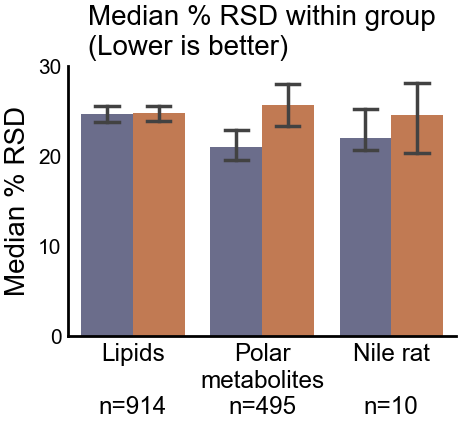

In [801]:
# hldf = pd.DataFrame(
#     [[20.4, 'fed', 'nile'],
#      [23.1, 'fasted', 'nile'],
#      [18.5, 'fed', 'lipid'],
#      [20.7, 'fasted', 'lipid'],
#      [22.8, 'fed', 'metabolite'],
#      [24.6, 'fasted', 'metabolite']
#     ], columns=['%RSD', 'bg_type', 'cat'])
# hldf

per_animal['cat'] = 'Within\nNile rat'
per_class['cat'] = per_class['Type']
append = per_animal.append(per_class)

all_l = (gb
 .loc[:, data.loc[data['Type'] == 'lipid'].index]
 .groupby('bg_type')
 .median()
 .T
 .melt(value_name='% RSD')
)
all_l['Type'] = 'lipid'
all_l['Blood sampling'] = all_l['bg_type']

all_m = (gb
 .loc[:, data.loc[data['Type'] == 'metabolite'].index]
 .groupby('bg_type')
 .median()
 .T
 .melt(value_name='% RSD')
)
all_m['Type'] = 'metabolite'
all_m['Blood sampling'] = all_m['bg_type']

per_animal['Type'] = 'Nile rat'
per_animal['Blood sampling'] = per_animal['bg_type'].map({'Non-fasted': 'RBG', 'Fasted': 'FBG'})

acdf = all_l.append(all_m).append(per_animal)
acdf['Blood sampling'] = acdf['Blood sampling'].map({'RBG': 'Fed', 'FBG': 'Fasted'})

acdf

fig, ax = plt.subplots(dpi=250, figsize=(2.0, 1.4))

ESTIMATOR = np.median #np.mean
if ESTIMATOR == np.median:
    est_text = 'Median'
elif ESTIMATOR == np.mean:
    est_text = 'Average'
sns.barplot(
    data=acdf, x='Type', y='% RSD', ax=ax,
    hue='Blood sampling', palette=colors, hue_order=['Fed', 'Fasted'], saturation=1,
    ci=95, capsize=0.18, errwidth=1, 
    estimator=ESTIMATOR
)
ax.text(0.05, 1.02, f'{est_text} % RSD within group\n(Lower is better)', fontsize=8,
        transform=ax.transAxes, va='bottom')
ax.set_xlabel(None)
ax.set_ylabel(f'{est_text} % RSD')
ax.set_xticks([0, 1, 2], [ 
                          f'Lipids\n\nn={len(data.loc[data["Type"] == "lipid"])}', 
                          f'Polar\nmetabolites\nn={len(data.loc[data["Type"] == "metabolite"])}',
                          'Nile rat\n\nn=10',
],
              ha='center', fontweight='normal', fontsize=7)
ax.set_yticks(range(0, 35, 10))
ax.tick_params(length=0)
ax.legend(loc=(1, 0), title='Blood\nsampling').remove()
sns.despine()
# plt.savefig('../reports/figures/Figure3/RSD_groups_bar_chart.pdf', bbox_inches='tight', dpi=300)

0


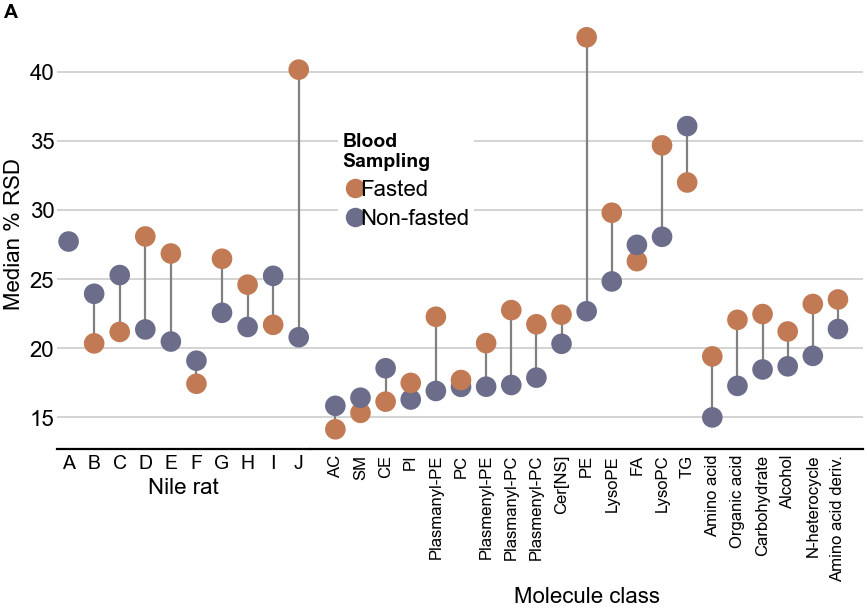

In [169]:
importlib.reload(src.plots)
fig, (ax1, ax2) = plt.subplots(
    dpi=200, figsize=(5.2, 2.8), 
    ncols=2, gridspec_kw=dict(width_ratios=[0.87, 1.9], wspace=0), sharey=True)

hue_order = ['Fasted', 'Non-fasted', ]
s = 55
sns.scatterplot(
    data=per_animal, x='Nile rat label', y='% RSD', hue='bg_type', hue_order=hue_order, palette=colors, ax=ax1,
    linewidth=0, edgecolors='none', zorder=2, s=s, legend=False)

# per_class = per_class.sort_values('Type', ascending=False)
sns.scatterplot(
    data=per_class, x='molec_class', y='% RSD', hue='bg_type', hue_order=hue_order, palette=colors, ax=ax2,
    linewidth=0, edgecolors='none', legend=False, zorder=2, s=s)

for ax, df in [(ax1, per_animal), (ax2, per_class)]:
    for loc in df['loc'].unique():
        sdf = df.loc[df['loc'] == loc]
        try: 
            nonfasted_rsd = sdf.loc[sdf['bg_type'] == 'Non-fasted', '% RSD'].values[0]
            fasted_rsd    = sdf.loc[sdf['bg_type'] == 'Fasted', '% RSD'].values[0]
            ax.plot([loc, loc], [fasted_rsd, nonfasted_rsd], color='gray', lw=0.8, zorder=1,)
        except IndexError:
            print(loc)
        
classes = per_class['molec_class'].unique()
classes[-1] = 'Amino acid deriv.'
classes[-2] = 'N-heterocycle'

ax1.set_xlabel('Nile rat')
ax1.set_ylabel('Median % RSD')
ax2.set_xlabel('Molecule class')
ax2.set_xticks(ticks=range(len(classes)), labels=classes)

ax1.tick_params(axis='x', rotation=0, length=0, pad=2, labelsize=7)
ax2.tick_params(axis='x', rotation=90, length=0, pad=2, labelsize=6)
ax1.tick_params(axis='y', length=0, pad=1, labelsize=8)
ax2.tick_params(axis='y', length=0)

for ax in (ax1, ax2):
    ax.grid(axis='y', color=src.plots.GRID_LIGHT_COLOR, lw=src.plots.GRID_LW)
    ax.set_axisbelow(True)

src.plots.custom_legend(
    entries=['Non-fasted', 'Fasted'], ax=ax2, loc=(0.05, 0.5),
    sort=False, title='Blood\nSampling',
    mew=0, ms=7, handletextpad=-0.3, show_frame=True, frame_color='1', 
)
bb = src.plots.tight_bbox(ax1)
ax1.text(x=bb.x0, y=bb.y1, s='A', fontsize=src.plots.LABEL_FONTSIZE, transform=fig.transFigure, fontweight='bold')

sns.despine(ax=ax1, left=True)
sns.despine(ax=ax2, left=True)
# plt.savefig('../reports/figures/Figure3/RSDs_vertical.pdf', dpi=300, bbox_inches='tight')

# Similar to what Roz Anderson mentioned: is there an OGTT glucAUC dependence on variance within lipid classes, within sampling method? 
## Roz mentioned that an increase in variance of SMs is an indicator for diabetes 
- A naive calculation would be to do a heteroskedasticity test on each metabolite in a quant vs OGTT plot
    - However this would fail to capture class-wide trends 
    - Would be underpowered considering that lipids are strongly co-regulated
- Could do correlation: 
    - Within each molec_class:
        - Perform Correlation between Nile rat's RSD of all metabolites within that class versus Nile rat's OGTT glucAUC

# Conclusion:
### Boxplots show no evidence for OGTT glucAUC dependence on RSD within molec_class or within superclass for lipids
- Boxplots were ordered by increasing OGTT glucAUC

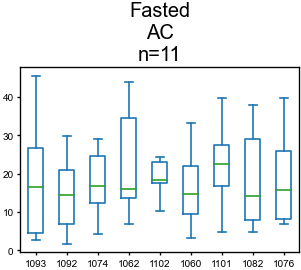

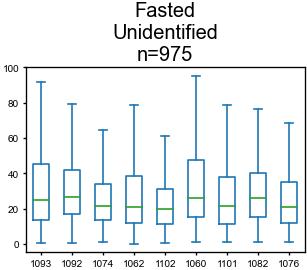

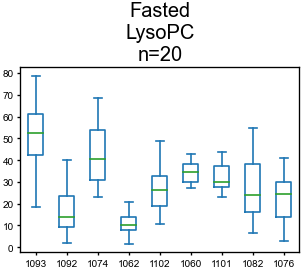

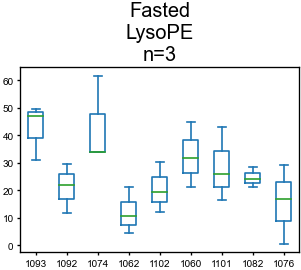

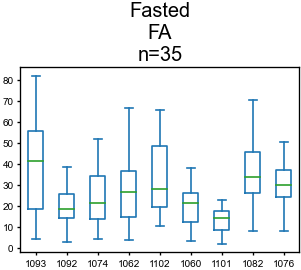

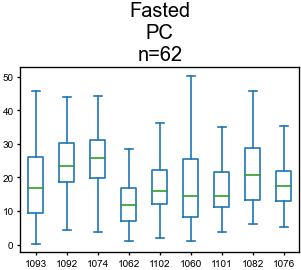

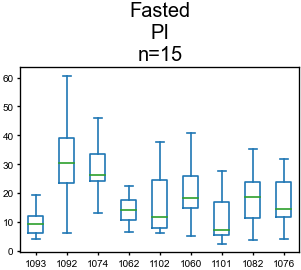

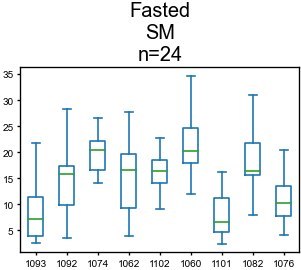

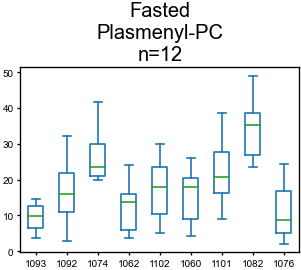

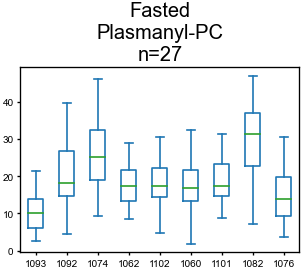

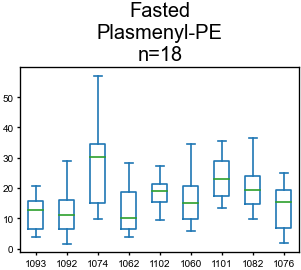

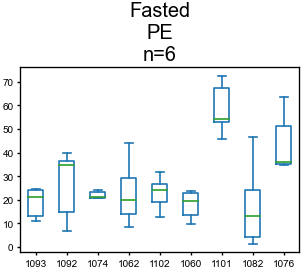

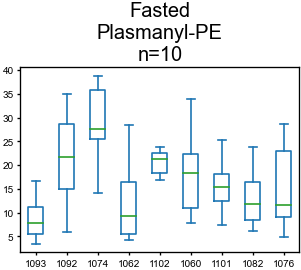

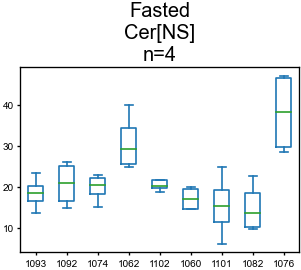

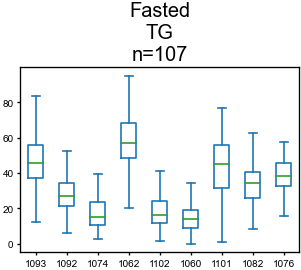

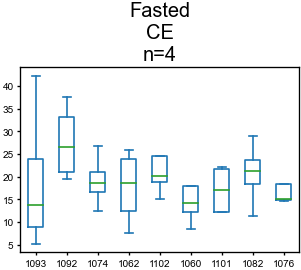

In [231]:
ogtt_order = ap.loc[ap['original'], 'OGTT (AUC)'].sort_values().index.astype('str')[1:]
category = 'molec_class'
for cls in data.loc[(data['Type'] == 'lipid'), category].unique():
    class_idxs = data.loc[data[category] == cls].index
    tdf = gb.loc[gb.index.get_level_values('bg_type') == 'RBG', class_idxs]#.mean(axis=1)
    tdf = (tdf
           .reset_index()
           .set_index('animal')
           .loc[ogtt_order]
           .drop('bg_type', axis=1)
           .T
          )
    tdf.plot.box( showfliers=False)  # positions=[int(x) for x in ogtt_order],
    plt.gcf().set_size_inches(3, 2)
    plt.title('Fasted\n' + cls + f'\nn={len(tdf)}')

# Horizontal orientation version

IndexError: index 0 is out of bounds for axis 0 with size 0

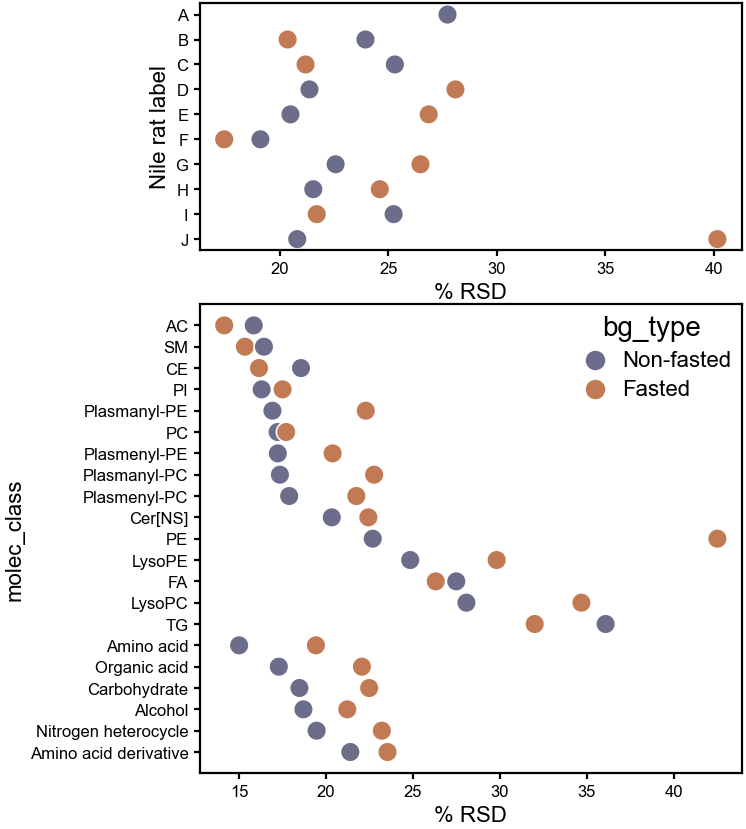

In [171]:
importlib.reload(src.plots)
fig, (ax1, ax2) = plt.subplots(
    dpi=200, figsize=(3.5, 5), 
    ncols=1, nrows=2, gridspec_kw=dict(height_ratios=[1, 1.9], hspace=0.15),
)

hue_order = ['Non-fasted', 'Fasted']
s = 50
sns.scatterplot(
    data=per_animal, 
    y='Nile rat label', x='% RSD', 
    hue='bg_type', hue_order=hue_order, palette=colors, ax=ax1,
    linewidths=0, edgecolors='none', zorder=2, s=s, legend=False,
)

sns.scatterplot(
    data=per_class, 
    y='molec_class', x='% RSD', 
    hue='bg_type', hue_order=hue_order, palette=colors, ax=ax2,
    linewidths=0, edgecolors='none', legend=True, zorder=2, s=s,
)

for ax, df in [(ax1, per_animal), (ax2, per_class)]:
    for loc in df['loc'].unique():
        sdf = df.loc[df['loc'] == loc]
        fasted_rsd =    sdf.loc[sdf['bg_type'] == 'Fasted', '% RSD'].values[0]
        nonfasted_rsd = sdf.loc[sdf['bg_type'] == 'Non-fasted', '% RSD'].values[0]
        ax.plot([fasted_rsd, nonfasted_rsd], [loc, loc], color='gray', lw=0.8, zorder=1,)
    
classes = per_class['molec_class'].unique()
classes[-1] = 'Amino acid deriv.'
classes[-2] = 'N-heterocycle'
ax2.set_yticks(ticks=range(len(classes)), labels=classes)
# ax2.tick_params(rotation=90)
# ax2.tick_params(axis='y', length=0)
ax2.set_ylabel('Lipid class')
# ax1.tick_params(axis='y', length=0)
ax1.set_ylabel('Nile rat')
# ax1.set_title('Median metabolite % RSD', loc='left')
ax1.set_xlabel('Median % RSD')
ax2.set_xlabel('Median % RSD')
ax1.set_xlim(ax2.get_xlim())

for ax in (ax1, ax2):
    ax.grid(axis='x', color=src.plots.GRID_LIGHT_COLOR, lw=src.plots.GRID_LW)
    ax.set_axisbelow(True)

legend = src.plots.custom_legend(['Fed', 'Fasted'], ax=ax2, title='Sampling',
    loc=(0.7, 0.8), fontsize=7, show_frame=True)
bb = src.plots.tight_bbox(ax1)
# ax1.text(x=bb.x0, y=bb.y1, s='A', fontsize=src.plots.LABEL_FONTSIZE, transform=fig.transFigure, fontweight='bold')
sns.despine()

# plt.savefig('../reports/figures/Figure3/RSDs_horizontal.pdf', dpi=300, bbox_inches='tight')

## Calculate within-animal RSD for all lipids (ID and un-ID) to compare to Figure 7B

## Supplemental figure

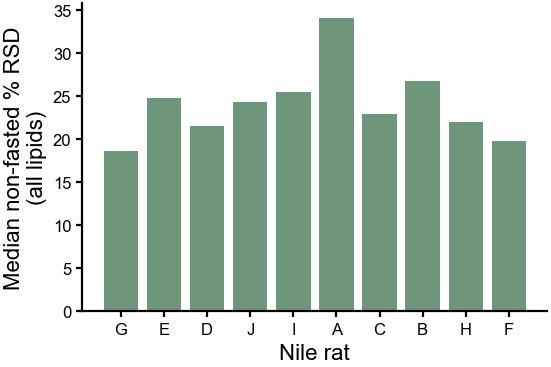

In [830]:
fig, ax = plt.subplots(dpi=200, figsize=(3, 2))
all_lipids_per_animal = gb.loc[
    gb.index.get_level_values('bg_type') == 'RBG', 
    data.loc[data['Type']=='lipid'].index
]
ogtt_order = ap.loc[ap['original']].sort_values('Nile rat label').index
lip_meds = all_lipids_per_animal.median(axis=1)
ax.bar(range(10), lip_meds, color=colors['M'], alpha=0.8)
ax.set_xticks(
    range(10), 
    lip_meds.index.get_level_values('animal').astype('int').map(ap['Nile rat label'])
)
ax.set_xlabel('Nile rat')
ax.set_ylabel('Median non-fasted % RSD\n(all lipids)')
sns.despine()
# plt.savefig('../reports/figures/FigureSupp/10wk_lipids_RSD.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('../reports/figures/FigureSupp/10wk_lipids_RSD.png', bbox_inches='tight', dpi=300)

# Nile rat bulk phenotype reproducibility plots

## Supplemental figure

In [831]:
ddf

molec_class            AC    Alcohol  Amino acid  Amino acid derivative  \
animal bg_type                                                            
1060   FBG      24.925194  16.642241   16.119631              24.492298   
       RBG      14.793455  31.609509   17.168171              51.361298   
1062   FBG      10.216885  34.244416   27.480255              27.963175   
       RBG      16.055707  13.380854   13.050384              18.781986   
1074   FBG      34.693169  25.989572   19.957144              22.523749   
       RBG      16.852998  19.788522   14.777729              19.252431   
1076   FBG      14.140623  46.338608   44.788907              40.758458   
       RBG      15.620418  17.607717    8.849108              28.364999   
1082   FBG      11.222212  21.448765   14.475799              18.286903   
       RBG      14.057238  14.847794   17.870213              23.539521   
1091   RBG      13.471359  22.830204    8.790972              14.038061   
1092   FBG      12.676298  13.042341   19.416162              23.536183   
       RBG      14.339214  26.950593   27.288012              38.442391   
1093   FBG      20.505067  12.172434   10.712211              12.875869   
       RBG      16.559766   7.325950   15.220508              14.682020   
1101   FBG      17.640273  21.218898   25.138217              29.785492   
       RBG      22.406789  15.879138   13.681642              24.431179   
1102   FBG      12.838850  19.277570   14.079332              20.244917   
       RBG      18.447790  20.926055   15.281679              17.282164   

molec_class            CE  Carbohydrate    Cer[NS]         FA     LysoPC  \
animal bg_type                                                             
1060   FBG      16.141940     20.498044  17.442975  21.290356  36.139776   
       RBG      14.102260     26.821671  16.864104  21.353711  34.339687   
1062   FBG      23.180735     26.758063  28.337344  25.873321  46.241985   
       RBG      18.524515     17.426106  29.057768  26.748835  10.387248   
1074   FBG      26.558926     43.364845  29.496417  26.309746  33.001760   
       RBG      18.592662     15.083283  20.472446  21.367378  40.605774   
1076   FBG      52.388688     42.229923  26.198903  35.891739  42.030138   
       RBG      15.013458     13.326001  38.168961  30.058726  24.231042   
1082   FBG      18.229234     13.742708  41.224092  27.958253  20.201965   
       RBG      21.318768     25.947917  13.599113  33.761909  23.793703   
1091   RBG      40.088794     20.454989  32.389506  33.728393  37.410119   
1092   FBG      16.104525     22.480500  21.551275  15.662001  16.718096   
       RBG      26.585335     31.008521  20.772883  18.573635  13.786596   
1093   FBG      10.953280     17.834800  14.541734  29.240087  48.198222   
       RBG      13.859306     15.753077  18.327243  41.477705  52.579376   
1101   FBG      15.180563     34.270865  22.433970  26.840093  34.689132   
       RBG      17.001566     10.528830  15.232924  14.445359  29.849327   
1102   FBG      10.870496     15.447476  16.032498  15.543234  23.203917   
       RBG      20.120730     19.512264  20.183194  28.229936  26.296589   

molec_class        LysoPE  ...         PC         PE         PI  Plasmanyl-PC  \
animal bg_type             ...                                                  
1060   FBG      29.813773  ...  22.274480  45.980588   8.022537     30.427120   
       RBG      31.581009  ...  14.429203  19.512070  18.264910     16.951947   
1062   FBG      51.249971  ...  25.105789  30.666942  22.684591     34.666203   
       RBG      10.571766  ...  11.862654  19.951167  13.952481     17.301441   
1074   FBG      19.407854  ...  19.230101  45.241634  44.292961     22.764818   
       RBG      33.873535  ...  25.711164  21.079177  26.400274     25.182341   
1076   FBG      37.107343  ...  30.131794  44.944490  32.645977     31.403470   
       RBG      16.778143  ...  17.430150  36.228004  14.324370     13.802097   
1082   FBG       

In [864]:
from scipy.stats import ttest_1samp

time_cols = ddf.columns[1:14]

dev_from_mean = ddf[time_cols].sub(ddf['mean'], axis=0).div(ddf['mean'], axis=0)

r = {}
for colname, col in dev_from_mean.iteritems():
#     print(col)
    r[colname] = ttest_1samp(col, 0).pvalue
fdrcorrection(list(r.values()))

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False]),
 array([0.37604818, 0.37604818, 0.91634096, 0.91634096, 0.96345875,
        0.91634096, 0.48006549, 0.62330901, 0.91634096, 0.91634096,
        0.62330901, 0.62330901, 0.62330901]))

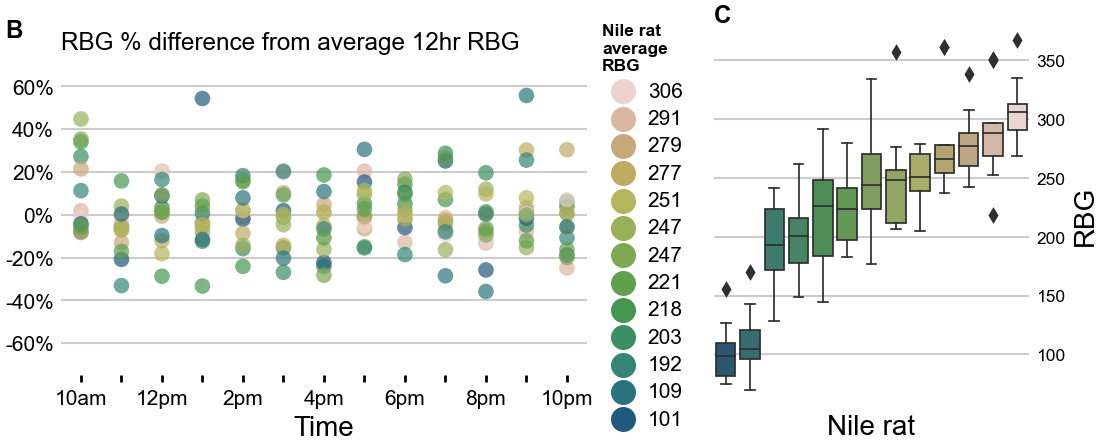

In [834]:
importlib.reload(src.plots)
fig, axs = plt.subplot_mosaic(
    """
    .C
    BC
    .C
    """,
    dpi=250, figsize=(5, 2), gridspec_kw=dict(width_ratios=[1, 0.6], wspace=0.3,
                                              height_ratios=[0.1, 1, 0.1], hspace=0,),
)
ax, ax2 = axs['B'], axs['C']

palette = 'gist_earth'  # crest  flare  gist_earth PuBuGn viridis cividis
palette = sns.color_palette('gist_earth', 15)[2:]
sns.stripplot(
# sns.boxplot(
    data=mddf, x='Time', y='mean_%_diff', ax=ax, 
#     dodge=False,
    jitter=False, 
    alpha=0.7,
    hue='mean_rank', palette=palette,
#     hue='sex', palette=colors,
    linewidth=0, s=4.5,
)
xticks = ['10am', '', '12pm', '', '2pm', '', '4pm', '', '6pm', '', '8pm', '', '10pm']
ax.tick_params(axis='x', labelsize=6, length=2)
ax.set_xticks(ax.get_xticks(), xticks)
ax.tick_params(axis='y', length=0)
yticks = [-60, -40, -20, 0, 20, 40, 60]
ax.set_yticks(yticks, [str(x)+'%' for x in yticks], fontsize=6)
ax.set_ylabel(None)
ax.set_ylim(-75, 75)
ax.set_title('RBG % difference from average 12hr RBG', loc='left', fontsize=src.plots.LABEL_FONTSIZE, va='top')
ax.grid(axis='y', color=src.plots.GRID_LIGHT_COLOR, lw=src.plots.GRID_LW)

rbg_order = ddf.sort_values('mean').index
sns.boxplot(
    data=mddf, x='animal', y='RBG', order=rbg_order, hue='mean', palette=palette, ax=ax2, 
    linewidth=0.5, dodge=False, fliersize=2,
)
ax2.set_xlabel('Nile rat')
ax2.tick_params(axis='x', length=0)
ax2.set_xticks([])
ax2.tick_params(axis='y', labelsize=5, length=0)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.grid(axis='y', color=src.plots.GRID_LIGHT_COLOR, lw=src.plots.GRID_LW)
ax2.get_legend().remove()

rounded_mean_rbg = ddf.sort_values('mean')['mean'].round(0).astype('int').astype('str').to_list()
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    handles=handles[::-1], labels=rounded_mean_rbg[::-1], loc=(1.02, -0.18), 
    markerscale=0.8,
    fontsize=src.plots.LEGEND_TEXT_FONTSIZE, 
    title_fontproperties=dict(size=src.plots.LEGEND_TITLE_FONTSIZE - 2, weight='bold'),
    title='Nile rat\naverage\nRBG')
legend._legend_box.align = 'left'

for ax, letter in zip([ax, ax2], ['B', 'C']):
    bb = src.plots.tight_bbox(ax)
    if letter == 'B': 
        y = bb.y1 * 0.96
    else:
        y = bb.y1
    ax.text(x=bb.x0, y=y, s=letter,
            fontsize=src.plots.LABEL_FONTSIZE, transform=fig.transFigure, fontweight='bold')

sns.despine(bottom=True, left=True)
# plt.savefig('../reports/figures/Figure3/12hr_RBGs.pdf', dpi=300, bbox_inches='tight')

In [174]:
sns.lineplot(data=rdf, x='week', y='r%', hue='Nile rat label', palette=colors, )
plt.figure()
sns.stripplot(data=rdf, x='Nile rat label', y='r%', hue='Nile rat label', dodge=False,  palette=colors,)
plt.figure()
sns.lineplot(data=fdf, x='week', y='f%', hue='Nile rat label', palette=colors, )
plt.figure()
sns.stripplot(data=fdf, x='Nile rat label', y='f%', hue='Nile rat label', dodge=False,  palette=colors,)
plt.figure()
sns.scatterplot(data=bgs, x='Nile rat label', y='frsd', color=colors['FBG'])
sns.scatterplot(data=bgs, x='Nile rat label', y='rrsd', color=colors['RBG'])

ValueError: The palette dictionary is missing keys: {'B', 'C', 'D', 'E', 'G', 'J', 'A', 'I', 'H'}

# For each molec_class within each Nile rat, what is the difference between fasted and fed RSDs? 

In [561]:
ddf = gb.groupby(data['molec_class'], axis=1).median()
# display(ddf)
# ddf = ddf.drop('1091', level='animal')
rdf = ddf.loc[ddf.index.get_level_values('bg_type') == 'RBG'].droplevel('bg_type')
fdf = ddf.loc[ddf.index.get_level_values('bg_type') == 'FBG'].droplevel('bg_type')
sdf = rdf - fdf
col_order = data.sort_values(['Type', 'molec_class'])['molec_class'].unique()
ogtt_order = ap.loc[ap['original'], 'OGTT (AUC)'].sort_values().index.astype('str')
sdf = sdf.loc[ogtt_order, col_order]
sdf.columns = sdf.columns.map(class_abbrevs)
sdf = sdf.drop(['1091'])
sdf = sdf.T
sdf

animal,1093,1092,1074,1062,1102,1060,1101,1082,1076
molec_class,,,,,,,,,
AC,-3.945301,1.662916,-17.840171,5.838822,5.608939,-10.131739,4.766516,2.835026,1.479795
CE,2.906026,10.480810,-7.966264,-4.656220,9.250234,-2.039680,1.821003,3.089534,-37.375230
Cer,3.785509,-0.778392,-9.023971,0.720424,4.150697,-0.578871,-7.201046,-27.624979,11.970058
FA,12.237618,2.911633,-4.942369,0.875514,12.686702,0.063355,-12.394734,5.803656,-5.833013
LPC,4.381154,-2.931500,7.604015,-35.854738,3.092672,-1.800089,-4.839805,3.591738,-17.799096
LPE,7.613325,-10.628778,14.465681,-40.678205,-5.386292,1.767236,12.563405,15.122967,-20.329200
PC,2.138159,8.383269,6.481063,-13.243135,-1.021695,-7.845277,-3.342139,7.037780,-12.701644
PE,-12.523939,-7.941119,-24.162457,-10.715775,9.908359,-26.468518,12.130862,-33.821287,-8.716486
PI,-4.043739,18.817458,-17.892687,-8.732110,-5.381937,10.242373,-10.527437,1.189146,-18.321607


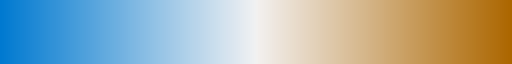

In [785]:
sns.diverging_palette(250, 40, l=50, s=100, center='light', as_cmap=True)

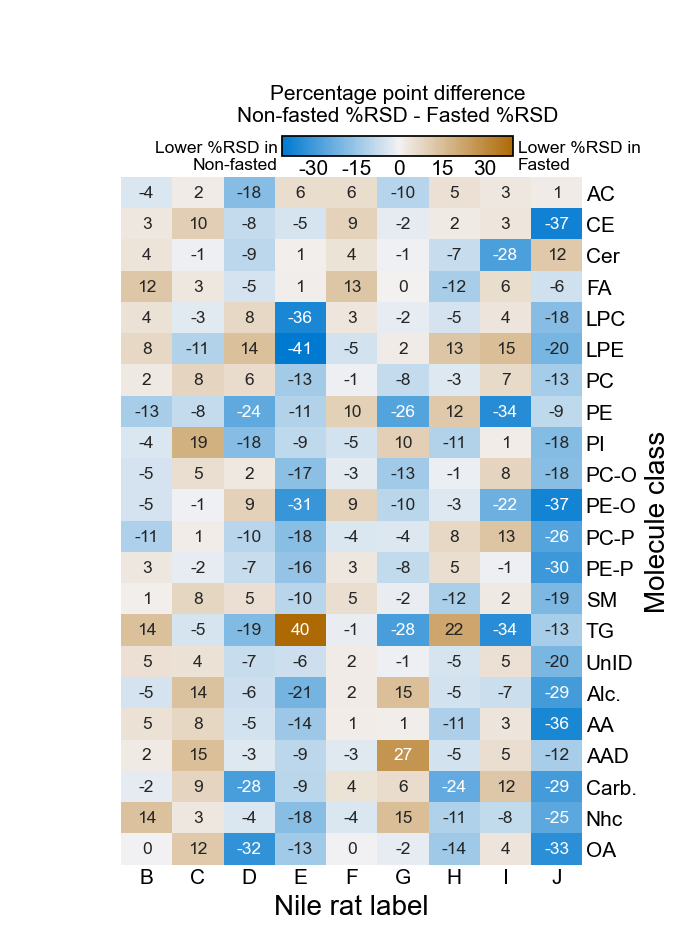

In [787]:
cmap = sns.diverging_palette(250, 40, l=50, s=100, center='light', as_cmap=True)

# vmin, vmax = -35, 15
vmin, vmax = sdf.min().min(), sdf.max().max()
cm = sns.clustermap(
    sdf,
    cmap=cmap,
    col_cluster=False, row_cluster=False,
    cbar_pos=None,
    figsize=(3,4),
    center=0,
    annot=sdf.round(0).astype('int').values, annot_kws=dict(fontsize=5),
)
fig = plt.gcf()
fig.set_dpi(250)
axh = cm.ax_heatmap
axh.set(ylabel='Molecule class', xlabel='Nile rat label')
axh.set_xticks(np.arange(sdf.shape[1])+0.5, 
                         sdf.columns.astype('int').map(ap['Nile rat label']))
cbar, cax = src.plots.custom_colorbar(
    ax=axh, vmin=vmin, vmax=-1*vmin, vcenter=0, cmap=cmap,
    bbox=[0.35, 1.03, 0.5, 0.03], orientation='horizontal', #extend='both', extendfrac=0.03,
)
cax.set_title('Percentage point difference\nNon-fasted %RSD - Fasted %RSD', fontsize=6,)
cax.set_xlim(vmin, vmax)
cax.set_xticks([-30, -15, 0, 15, 30])
cax.text(-0.02, 0, 'Lower %RSD in\nNon-fasted', va='center', ha='right', transform=cax.transAxes, fontsize=5)
cax.text(1.02, 0, 'Lower %RSD in\nFasted', va='center', ha='left', transform=cax.transAxes, fontsize=5)
for ax in [*fig.get_axes(), cax]:
    ax.tick_params(length=0, pad=1)
    
plt.savefig('../reports/figures/Figure3/Heatmap_RSD_diff_fasted_fed_rats_and_molec_class.pdf',
            bbox_inches='tight', dpi=300)    

# For each individual metabolite, what is diff between fasted and fed within animal? 

## This plot is not great because of the number of IDs

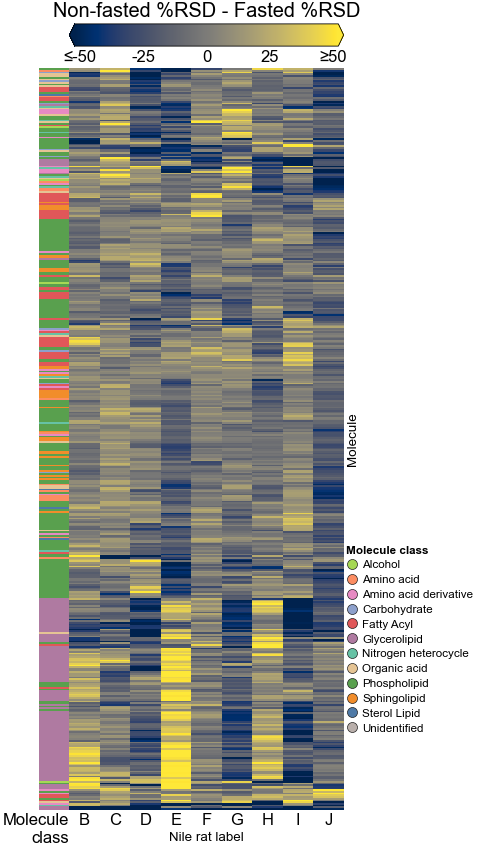

In [767]:
gbdiff = gb.drop('1091', level='animal').groupby(level='animal').diff()
gbdiff = gbdiff.loc[gbdiff.index.get_level_values('bg_type') == 'RBG']
sort_order = (data
              .loc[data['ID'] != 'Unidentified']
              .sort_values(['Type', 'molec_class', 'fa_carbons', 'fa_unsat']).index)
ogtt_order = ap.drop(1091).loc[ap['original'], 'OGTT (AUC)'].sort_values().index.astype('str')
gbdiff = (gbdiff
          .reset_index()
          .set_index('animal')
          .drop('bg_type', axis=1)
          .loc[ogtt_order, sort_order]
          .T
         )
gbdiff

vmin, vmax = -50, 50
row_colors = data.loc[gbdiff.index, 'molec_class'].map(colors).apply(lambda x: tuple(x))
# fig, ax = plt.subplots(figsize=(3, 8), dpi=140)
cm = sns.clustermap(
    data=gbdiff, 
    cmap='cividis', vmin=vmin, vmax=vmax,
    row_cluster=True, col_cluster=False,
    method='complete', metric='euclidean',
    dendrogram_ratio=0, colors_ratio=[0.1, 0],
    row_colors=col_colors,
#     row_colors=[(0.5, 0.5, 0.5)] * len(gbdiff),
    figsize=(3, 7),
    cbar_pos=None,
    yticklabels=[],
    xticklabels=gbdiff.columns.astype('int').map(ap['Nile rat label']),
)
fig = plt.gcf()
axh, axrc = cm.ax_heatmap, cm.ax_row_colors
axh

cbar, cax = src.plots.custom_colorbar(
    ax=axh, vmin=vmin-2, vmax=vmax+2, vcenter=0, cmap=sns.color_palette('cividis', as_cmap=True),
    bbox=(0, 1.03, 1, 0.03), extend='both', extendfrac=0.02, orientation='horizontal',
)
legend = src.plots.custom_legend(
    entries=data['superclass'].unique(), ax=axh, loc=[1, 0.1], title='Molecule class', fontsize=7, title_fontsize=7,
    ms=6,    
)
axh.set_xlabel('Nile rat label')
axh.set_ylabel('Molecule')
cax.set_title('Non-fasted %RSD - Fasted %RSD', rotation=0)
# cax.yaxis.set_major_locator(plt.LinearLocator(5))
cax.set_xticks([-50, -25, 0, 25, 50], ['≤-50', '-25', '0', '25', '≥50'])
axrc.set_xticks([0.99], ['Molecule\nclass'], ha='right')

for ax in [*fig.get_axes(), cax]:
    ax.tick_params(length=0, pad=2, rotation=0, labelsize=10)

# Figure 3 compiled plot (old version)

C:\Users\bjanderson23\anaconda3\lib\site-packages\seaborn\categorical.py:376: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.set_ylim(-.5, len(self.plot_data) - .5, auto=None)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


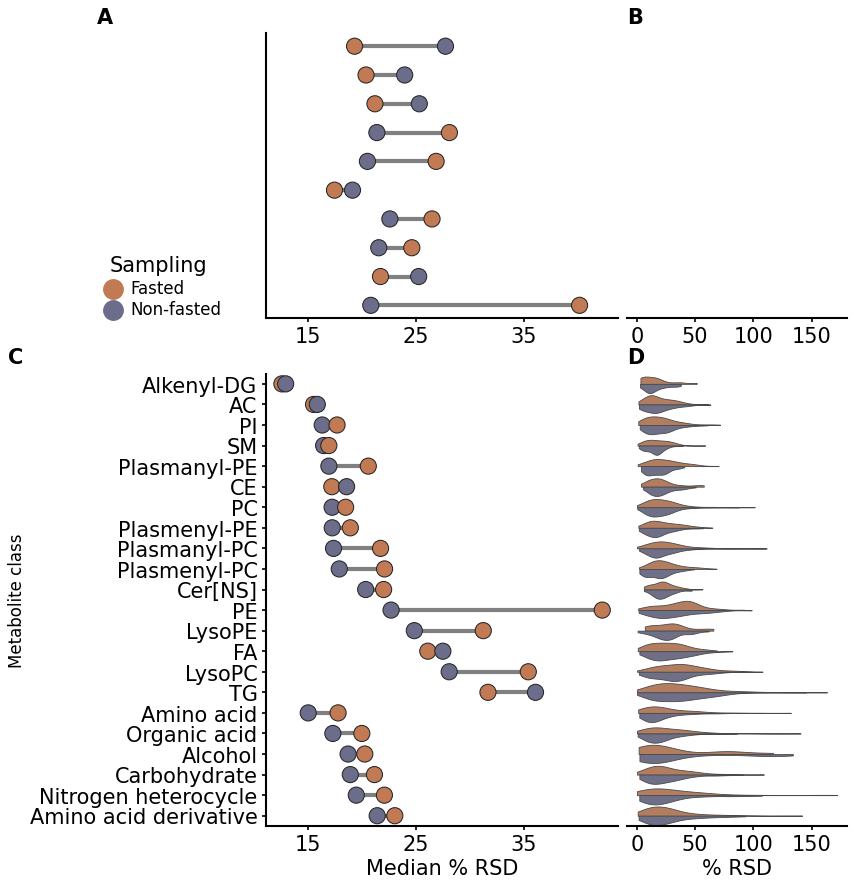

In [15]:
# plt.rcParams['xtick.major.pad'] = 1
# plt.rcParams['ytick.major.pad'] = 1
# plt.rcParams['xtick.major.size'] = 2
# plt.rcParams['ytick.major.size'] = 2
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 7

fig, axs = plt.subplots(
    ncols=2, nrows=2, figsize=(5, 7), dpi=150, sharex='col', sharey='row',
    gridspec_kw={'width_ratios': [1.6,1], 'height_ratios': [0.63,1], 
                 'wspace': 0.03, 'hspace':0.15})

###### B ######
ax = axs[0][1]
sns.violinplot(
    data=violin_data.sort_values('Nile rat label'), 
    x='value', y='Nile rat label', hue='bg_type', split=True, palette=colors, ax=ax,
    orient='h', linewidth=0.7, width=0.8, hue_order=['Non-fasted', 'Fasted'], inner=None,
    cut=0, bw=0.2, legend=False)
ax.set_ylabel(None)
ax.set_xlabel(None)
# ax.legend(loc=(-0.8, 0.4))
ax.tick_params(length=0, axis='y')
ax.tick_params(label1On=True, axis='x')
ax.legend([], [])

###### C ######
ax = axs[1][0]
sns.scatterplot(
    data=per_class,#.loc[per_class['molec_class']],
    x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax,
    s=60, hue_order=['Non-fasted', 'Fasted', ], linewidth=0.5, edgecolor='0.15')
y_loc_dict = {x: i for x, i in zip(per_class['molec_class'].unique(), range(len(per_class['molec_class'].unique())))}
per_class['y_loc'] = per_class['molec_class'].map(y_loc_dict)
for y_loc in range(len(y_loc_dict.values())):
    cls = per_class.loc[per_class['y_loc'] == y_loc, 'value']
    ax.plot([min(cls), max(cls)], [y_loc, y_loc], c='gray', linewidth=2, zorder=-10)
ax.set_xlabel('Median % RSD', fontsize=10)
ax.set_ylabel('Metabolite class')
ax.set_ylim(21.8, -0.8)
ax.set_xticks([15, 25, 35, 45])
handles, labels = ax.get_legend_handles_labels()
ax.legend([], [])

###### D
ax = axs[1][1]
sns.violinplot(
    data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
    x='value', y='molec_class', hue='bg_type', split=True, palette=colors, ax=ax,
    orient='h', linewidth=0.4, width=0.9, order=per_class['molec_class'].unique(), 
    inner=None, cut=0, bw=0.4, legend=False)
# ax.legend(loc=(-0.8, 0.8))
ax.tick_params(length=0, axis='y')
ax.set_ylabel(None)
ax.set_xticks([0, 50, 100, 150])
ax.set_xlabel('% RSD', fontsize=10)
ax.legend([], [])

###### A ######
ax = axs[0][0]
sns.scatterplot(
    data=per_animal, x='% RSD', y='Nile rat label', hue='bg_type', palette=colors, ax=ax,
    s=60, linewidth=0.5, legend=True, edgecolor='0.15')
y_loc_dict = {x: i for x, i in zip('ABCDEFGHIJ', range(10))}
per_animal['y_loc'] = per_animal['Nile rat label'].map(y_loc_dict)
for y_loc in range(len(y_loc_dict.values())):
    cls = per_animal.loc[per_animal['y_loc'] == y_loc, '% RSD']
    ax.plot([min(cls), max(cls)], [y_loc, y_loc], c='gray', linewidth=2, zorder=-10)
ax.tick_params(label1On=True, axis='x')
ax.legend(loc=(-0.48, 0), markerfirst=True, markerscale=1.5, borderpad=0, labelspacing=0.2,
          handletextpad=0, title='Sampling', fontsize=8)

for ax, letter in zip([axs[0][0], axs[0][1], axs[1][0], axs[1][1]], 'ABCD'):
    bb = src.plots.tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1+0.01, s=letter, transform=fig.transFigure, fontweight='bold')
    ax.spines[:].set_linewidth(1)

sns.despine(ax=axs[0][0])
sns.despine(ax=axs[1][0])
sns.despine(ax=axs[0][1], left=True)
sns.despine(ax=axs[1][1], left=True)

# plt.savefig('../reports/figures/Figure3/fig3.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('../reports/figures/Figure3/fig3.png', dpi=300, bbox_inches='tight')

## Data exploration of variance and correlation with:
1. FA unsaturations
2. FA carbon length
3. Superclass
4. Mean quant (check for heteroskedasticity) 

True     844
False    565
Name: nonfasted lower RSD, dtype: int64

<AxesSubplot:>

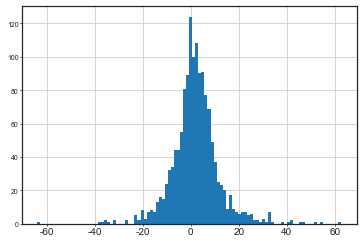

In [241]:
df = (gb
      .groupby(level=['bg_type'])
      .agg('mean')
      .T
      .join(data))
df['diff'] = df['FBG'] - df['RBG']
df['nonfasted lower RSD'] = df['RBG'] < df['FBG']
display(df['nonfasted lower RSD'].value_counts())
df['diff'].hist(bins=100)

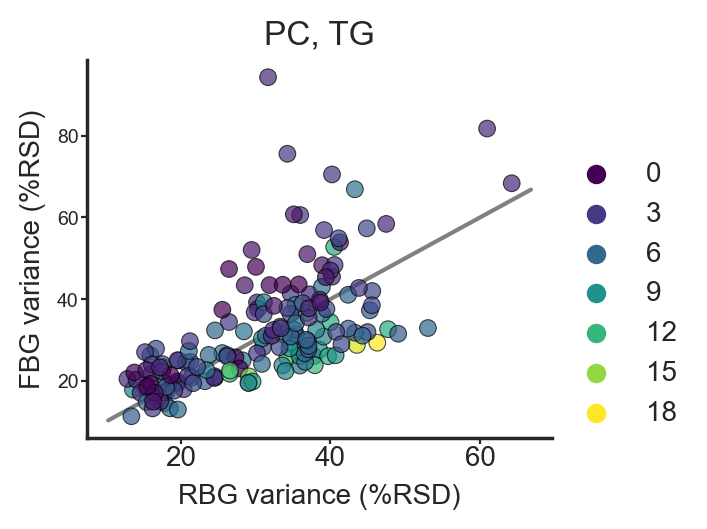

In [249]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)
subdf = df.loc[df['molec_class'].isin(['TG', 'PC'])]
# subdf = df.loc[df['molec_class'] != 'Unidentified'], 
# subdf = df.loc[df['molec_class'].str.contains('PC|PI|PE')],
sns.scatterplot(
    data=subdf,
    x='RBG', y='FBG', 
    hue='fa_unsat', palette='viridis',
#     hue='superclass', palette=colors, 
#     style='molec_class', markers=dict(TG='o', PC='s', FA='^'),
    ax=ax,
    alpha=0.7, linewidth=0.4, edgecolor='black', sizes=100,

)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], zorder=-10, color='gray')
ax.set(xlabel='RBG variance (%RSD)', 
       ylabel='FBG variance (%RSD)', 
       title=', '.join(subdf['molec_class'].unique()))
# ax.set_aspect('equal')
ax.legend(loc=(1.01, 0))
fig.set_facecolor('white')
sns.despine()

In [291]:
means = df[data_cols].groupby(axis=1, by=fg['bg_type']).mean().rename({'FBG': 'FBG_mean', 'RBG': 'RBG_mean'}, axis=1)
df = df.join(means)
means

bg_type,FBG_mean,RBG_mean
m_0,18.487555,18.765008
m_1,20.721830,21.654427
m_2,23.298066,22.957654
m_3,24.500973,23.803672
m_4,24.256320,25.154744
...,...,...
l_912,20.107645,20.634844
l_913,18.425069,19.083911
l_914,19.708654,18.289514
l_915,19.775257,18.041009


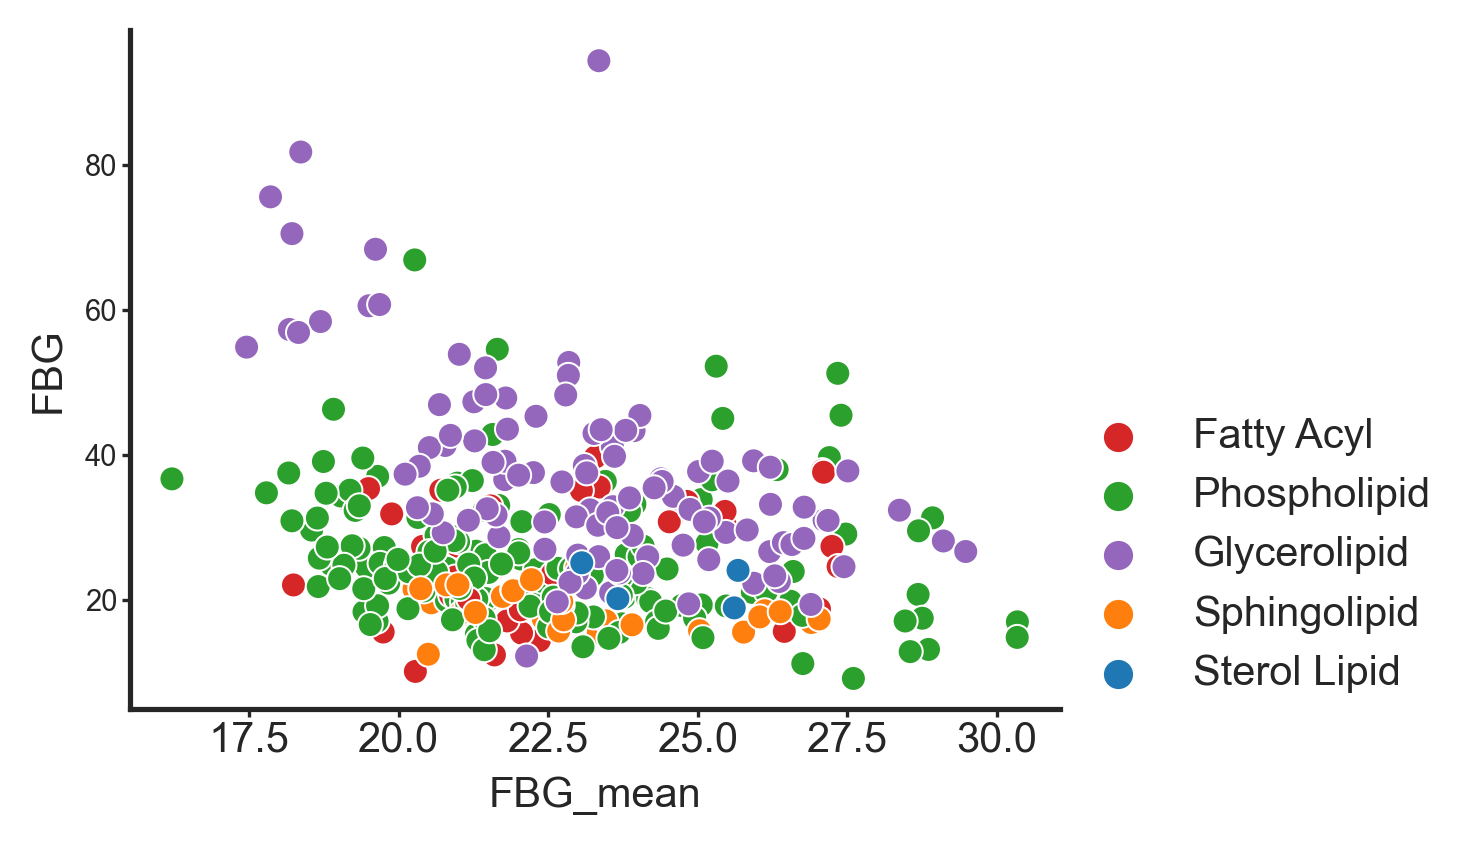

In [295]:
fig, ax = plt.subplots(dpi=300, figsize=(4,3))
sns.scatterplot(
    data=df.loc[(df['ID'] != 'Unidentified') & (df['Type'] == 'lipid')], ax=ax,
    x='FBG_mean', y='FBG', hue='superclass', palette=colors,
    
)
ax.legend(loc=(1, 0))
sns.despine()

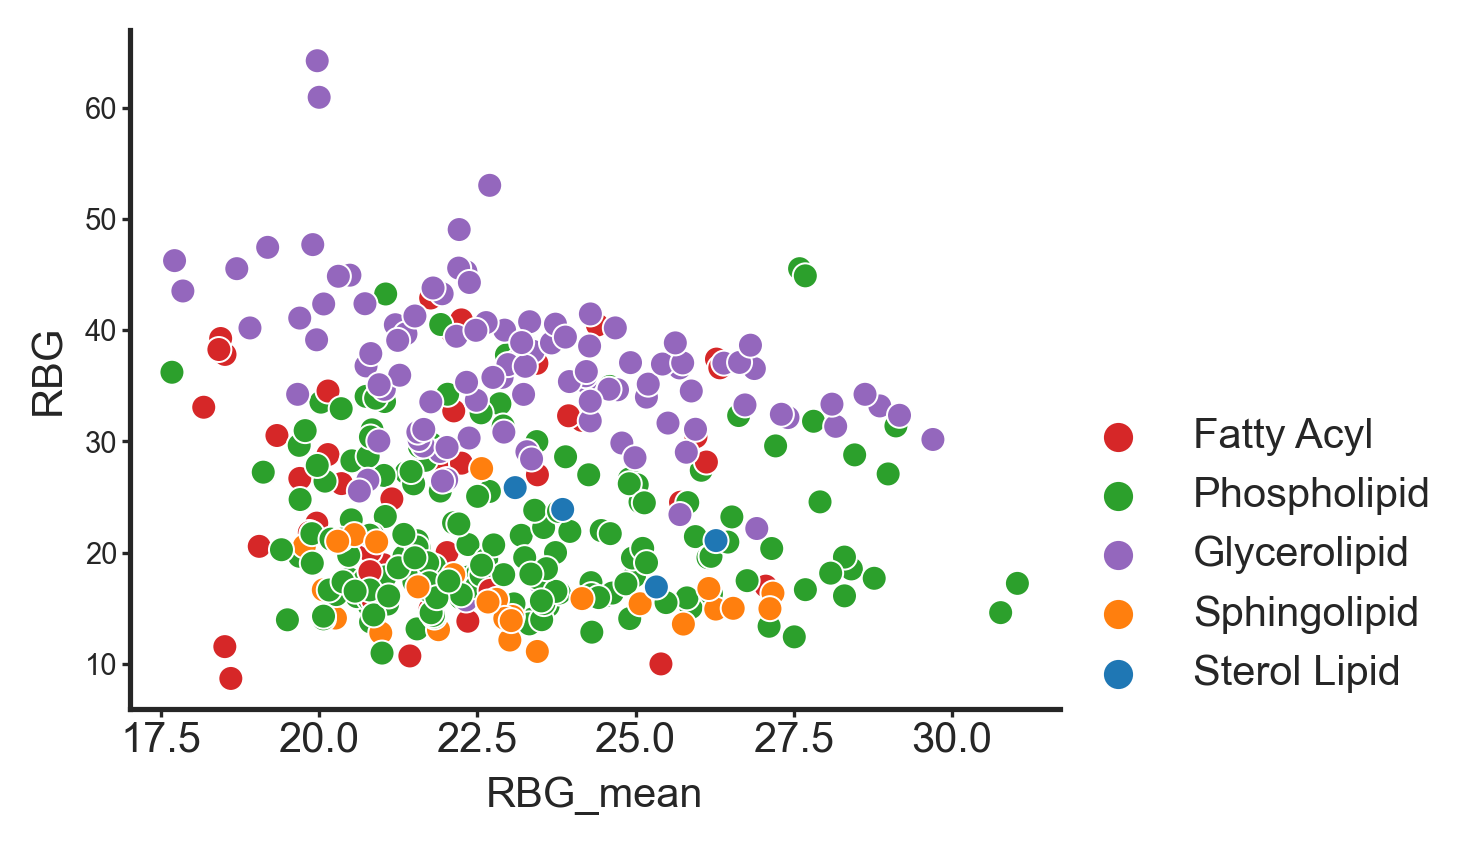

In [297]:
fig, ax = plt.subplots(dpi=300, figsize=(4,3))
sns.scatterplot(
    data=df.loc[(df['ID'] != 'Unidentified') & (df['Type'] == 'lipid')], ax=ax,
    x='RBG_mean', y='RBG', hue='superclass', palette=colors,
    
)
ax.legend(loc=(1, 0))
sns.despine()

In [209]:
data['fed_mean']

i
m_0      18.765008
m_1      21.654427
m_2      22.957654
m_3      23.803672
m_4      25.154744
           ...    
l_912    20.634844
l_913    19.083911
l_914    18.289514
l_915    18.041009
l_916    16.131177
Name: fed_mean, Length: 1409, dtype: float64

In [210]:
df = (gb
      .groupby('bg_type')
      .median()
      .T
      .join(data[['ID', 'molec_class', 'superclass', 'Type', 'fed_mean', 'fasted_mean']])
     )
df['rsd_diff'] = df['RBG'] - df['FBG']
df

,FBG,RBG,ID,molec_class,superclass,Type,fed_mean,fasted_mean,rsd_diff
m_0,42.979048,45.872677,Unidentified,Unidentified,Unidentified,metabolite,18.765008,18.487555,2.893630
m_1,17.880001,12.331371,Unidentified,Unidentified,Unidentified,metabolite,21.654427,20.721830,-5.548630
m_2,40.514368,35.620054,Urocanic acid,Nitrogen heterocycle,Nitrogen heterocycle,metabolite,22.957654,23.298066,-4.894315
m_3,14.555573,16.523040,Uridine,Nitrogen heterocycle,Nitrogen heterocycle,metabolite,23.803672,24.500973,1.967467
m_4,114.041335,83.032279,Uric acid,Nitrogen heterocycle,Nitrogen heterocycle,metabolite,25.154744,24.256320,-31.009056
...,...,...,...,...,...,...,...,...,...
l_912,30.729896,20.168092,TG 18:0_18:0_18:0,TG,Glycerolipid,lipid,20.634844,20.107645,-10.561805
l_913,62.456343,40.276451,Unidentified,Unidentified,Unidentified,lipid,19.083911,18.425069,-22.179892
l_914,43.982111,36.470274,Unidentified,Unidentified,Unidentified,lipid,18.289514,19.708654,-7.511837
l_915,47.854552,38.717386,Unidentified,Unidentified,Unidentified,lipid,18.041009,19.775257,-9.137165


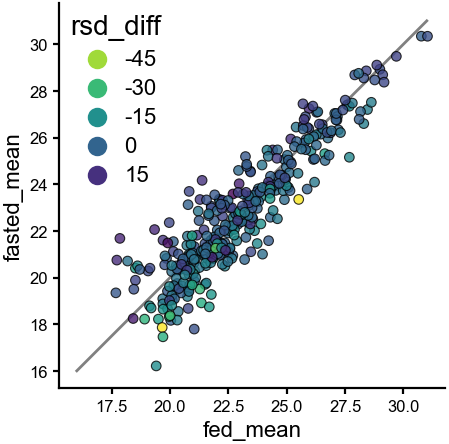

In [222]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)
sns.scatterplot(
    data=df.loc[(df['ID'] != 'Unidentified') & (df['Type'] == 'lipid')], ax=ax,
    x='fed_mean', y='fasted_mean', 
    hue='rsd_diff', palette='viridis_r',
#     hue='superclass', palette=colors,
#     size=
#     hue='superclass', palette=colors, 
#     style='molec_class', markers=dict(TG='o', PC='s', FA='^'),
    
    alpha=0.8, linewidth=0.4, edgecolor='black', s=12,
)
ax.plot([16, 31], [16, 31], color='0.5', zorder=-1, lw=1)

ax.set_aspect('equal')
sns.despine()

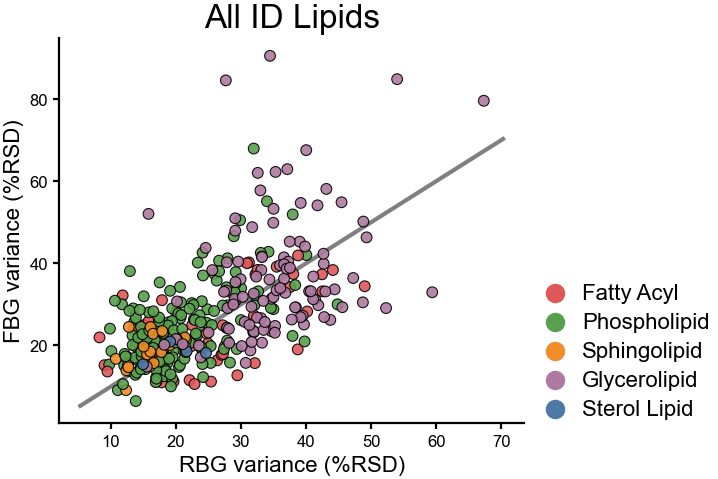

In [223]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)
sns.scatterplot(
#     data=df.loc[df['ID'].str.contains("22:6|20:5|22:5")],
    data=df.loc[(df['ID'] != 'Unidentified') & (df['Type'] == 'lipid')],
    x='RBG', y='FBG', 
    hue='superclass', palette=colors,
#     size=
#     hue='superclass', palette=colors, 
#     style='molec_class', markers=dict(TG='o', PC='s', FA='^'),
    ax=ax,
    alpha=0.9, linewidth=0.4, edgecolor='black', s=15,
)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], zorder=-10, color='gray')
ax.set(xlabel='RBG variance (%RSD)', 
       ylabel='FBG variance (%RSD)', 
#        title='All lipids with 22:6 or 20:5',
       title='All ID Lipids'
       )
# ax.set_aspect('equal')
ax.legend(loc=(1.01, 0))
fig.set_facecolor('white')
sns.despine()
plt.savefig('../reports/figures/Figure3/Scatterplot_fasted_vs_fed_RSD_per_metab.pdf',
            bbox_inches='tight', dpi=300)

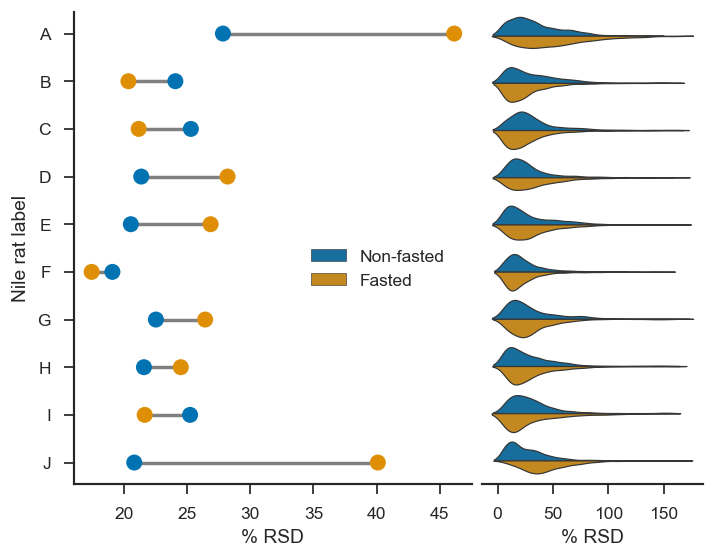

In [382]:
fig, axs = plt.subplots(ncols=2, figsize=(6.5, 5), dpi=125, 
                        gridspec_kw={'width_ratios': [1.8,1], 'wspace': 0.03})
ax = axs[0]
sns.scatterplot(
    data=per_animal,
    x='% RSD', y='Nile rat label', hue='bg_type', palette=colors, ax=ax,
    s=85, linewidth=0, legend=False,
)
y_loc_dict = {x: i for x, i in zip('ABCDEFGHIJ', range(10))}
per_animal['y_loc'] = per_animal['Nile rat label'].map(y_loc_dict)
for y_loc in range(len(y_loc_dict.values())):
    cls = per_animal.loc[per_animal['y_loc'] == y_loc, '% RSD']
    ax.plot([min(cls), max(cls)], [y_loc, y_loc], c='gray', linewidth=2, zorder=-10)
ax = axs[1]
sns.violinplot(
    data=violin_data.sort_values('Nile rat label'), 
    x='value', y='Nile rat label', hue='bg_type', split=True, palette=colors, ax=ax,
    orient='h', linewidth=0.7, width=0.8, hue_order=['Non-fasted', 'Fasted'], inner=None,
    cut=True, bw=0.2,
)
ax.set_xlabel('% RSD')
ax.set_xticks([0, 50, 100, 150])
ax.set_ylabel(None)
ax.set_yticks([])
ax.legend(loc=(-0.8, 0.4))
sns.despine(ax=ax, left=True)
sns.despine(ax=axs[0])

In [458]:
violin_data.loc[violin_data['molec_class'] != 'Unidentified']

,animal,bg_type,i,value,Nile rat label,molec_class
18010,1091,Fasted,l_405,59.491827,A,Plasmanyl-PE
15371,1091,Non-fasted,l_273,29.873659,A,Plasmanyl-PC
15370,1091,Fasted,l_273,38.512256,A,Plasmanyl-PC
25091,1091,Non-fasted,l_759,51.974787,A,TG
25090,1091,Fasted,l_759,102.612530,A,TG
...,...,...,...,...,...,...
11926,1076,Fasted,l_101,38.057468,J,FA
25666,1076,Fasted,l_788,50.116034,J,TG
25667,1076,Non-fasted,l_788,40.073587,J,TG
11927,1076,Non-fasted,l_101,34.736181,J,FA


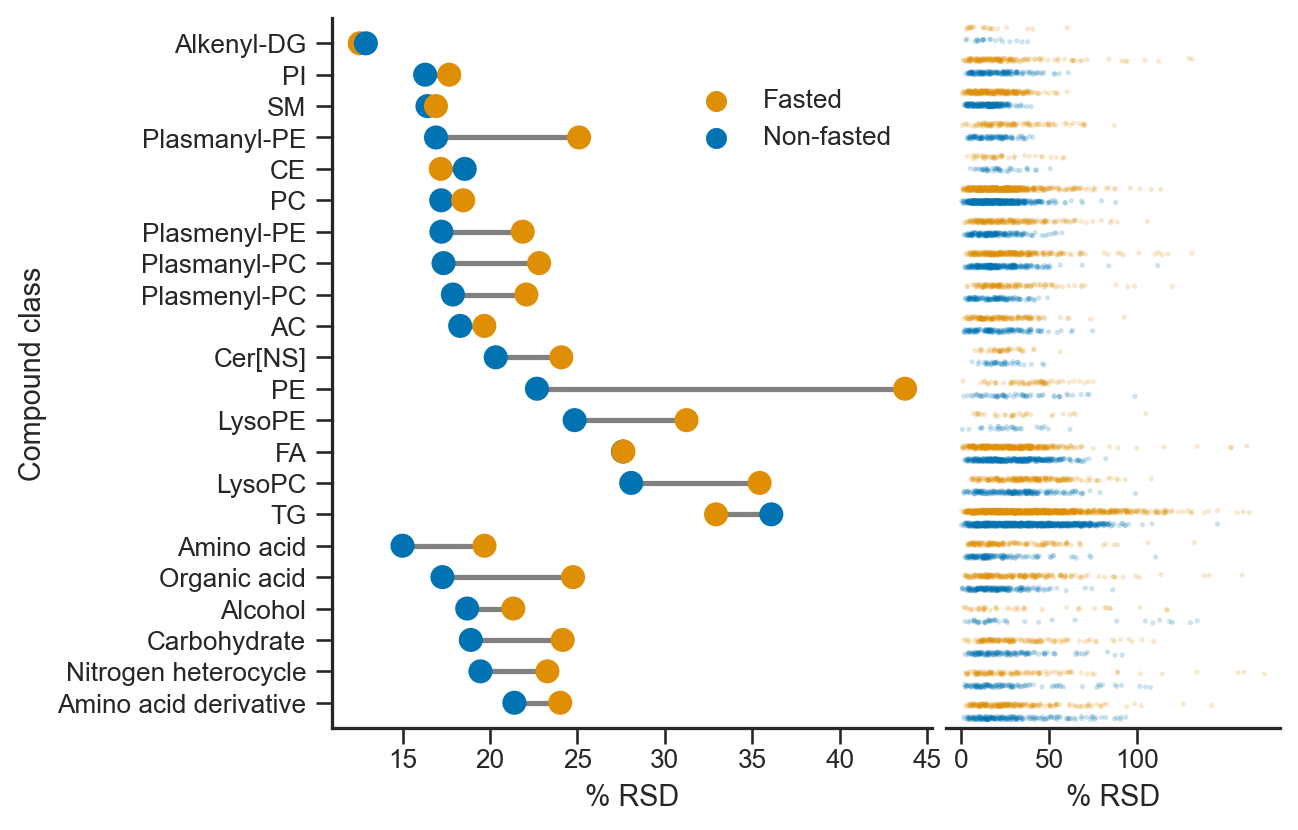

In [457]:
fig, axs = plt.subplots(ncols=2, figsize=(6.5, 5), dpi=188, 
                        gridspec_kw={'width_ratios': [1.8,1], 'wspace': 0.03})
ax = axs[0]
sns.scatterplot(
    data=per_class,#.loc[per_class['molec_class']],
    x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax,
    s=85, hue_order=['Fasted', 'Non-fasted'], linewidth=0,
)
y_loc_dict = {x: i for x, i in 
                zip(per_class['molec_class'].unique(), range(len(per_class['molec_class'].unique())))}
per_class['y_loc'] = per_class['molec_class'].map(y_loc_dict)
for y_loc in range(len(y_loc_dict.values())):
    cls = per_class.loc[per_class['y_loc'] == y_loc, 'value']
    ax.plot([min(cls), max(cls)], [y_loc, y_loc], c='gray', linewidth=2, zorder=-10)
ax.set_xlabel('% RSD')
ax.set_ylabel('Compound class')
# ax.axhspan(-0.7, 15.52, color=colors['lipid'],      label='Lipid',      alpha=0.22, zorder=-20, linewidth=0)
# ax.axhspan(15.5, 21.86, color=colors['metabolite'], label='Polar\nmetabolite', alpha=0.22, zorder=-20, linewidth=0)
ax.set_ylim(21.8, -0.8)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc=(1.01, 0.5))

ax = axs[1]
# sns.violinplot(
#     data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
#     x='value', y='molec_class', hue='bg_type', split=True, palette=colors, ax=ax,
#     orient='h', linewidth=0.4, width=0.9, order=per_class['molec_class'].unique(), 
#     inner=None, cut=True, bw=0.5,
# )
sns.stripplot(
    data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
    x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax,
    order=per_class['molec_class'].unique(), orient='h', linewidth=0, alpha=0.2, dodge=True, s=2
)

ax.legend(loc=(-0.8, 0.8))
ax.set_yticks([])
ax.set_ylabel(None)
ax.set_xticks([0, 50, 100])
ax.set_xlabel('% RSD')

sns.despine(ax=axs[1], left=True)
sns.despine(ax=axs[0])

# plt.savefig('../reports/figures/RSD_plots/RSD_plot_stripplot.pdf', dpi=150, bbox_inches='tight')

In [ ]:
# sns.stripplot(
#     data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
#     x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax,
#     order=per_class['molec_class'].unique(), orient='h', linewidth=0, alpha=0.2, dodge=True, s=2
# )
# sns.boxplot(
#     data=violin_data.loc[violin_data['molec_class'] != 'Unidentified'], 
#     x='value', y='molec_class', hue='bg_type', palette=colors, ax=ax, width=0.7,
#     order=per_class['molec_class'].unique(), orient='h', linewidth=0.3, showfliers=False,
# )

In [94]:
data_exp2 = data.copy()
data_exp2.loc[:, data_cols] = np.exp2(data_exp2.loc[:, data_cols])

In [95]:
df = data_exp2.loc[:, data_cols].T
# df = data_exp2.loc[data_exp2['Type'] == 'lipid', data_cols].T
df = df.join(fg[['bg_type', 'animal']])
gb = df.groupby(['animal', 'bg_type'], axis=0)
result = gb.std() / gb.mean()
result['mean_rsd'] = result.mean(axis=1) * 100
# result['median'] = result.median(axis=1)
# result.loc[result.index['bg_type'] == 'RBG']
result = result.reset_index()
result = result[['animal', 'bg_type', 'mean_rsd']]
result = result.pivot(index='animal', columns='bg_type', values='mean_rsd')
# result['diff'] = result['RBG'] - result['FBG']
result['rbg_better'] = result['RBG'] < result['FBG']
result['gluc_tol'] = result.index.map(ap['glucose_tolerance'])
# result = result.sort_values(['gluc_tol', 'rbg_better', 'RBG'], ascending=[True, True, True])
result = result.sort_values(['rbg_better', 'RBG'], ascending=[True, True])
result['y_index'] = range(len(result))
result['max_x'] = result[['RBG', 'FBG']].max(axis=1)
result['diff'] = round(result['FBG'] - result['RBG'], 1)
result['diff'] = result['diff'].apply(lambda x: f'+{str(x)}%' if x > 0 else f'‒{str(x)[1:]}%')
# result['y_index'] = range(len(result))

display(result)

vp_result = gb.std() / gb.mean() * 100 
vp_result = vp_result.reset_index()

vp_result = vp_result.melt(id_vars=['animal', 'bg_type'], value_vars=df.columns, value_name='rsd')
vp_result

bg_type,FBG,RBG,rbg_better,gluc_tol,y_index,max_x,diff
animal,,,,,,,
1102,22.902593,23.150130,False,impaired,0,23.150130,‒0.2%
1093,25.521981,31.378172,False,normal,1,31.378172,‒5.9%
1092,27.392891,31.435351,False,impaired,2,31.435351,‒4.0%
1076,45.581143,25.685489,True,diabetic,3,45.581143,+19.9%
1074,34.238233,26.501355,True,impaired,4,34.238233,+7.7%
1101,31.962604,28.085167,True,diabetic,5,31.962604,+3.9%
1062,32.609382,28.187944,True,impaired,6,32.609382,+4.4%
1082,32.495180,30.556074,True,diabetic,7,32.495180,+1.9%
1060,31.979793,31.495319,True,impaired,8,31.979793,+0.5%


,animal,bg_type,variable,rsd
0,1060,FBG,m_0,135.033146
1,1060,RBG,m_0,109.122505
2,1062,FBG,m_0,42.979048
3,1062,RBG,m_0,19.083103
4,1074,FBG,m_0,41.796211
...,...,...,...,...
27415,1093,RBG,l_872,38.184628
27416,1101,FBG,l_872,43.266060
27417,1101,RBG,l_872,34.610618
27418,1102,FBG,l_872,32.240494


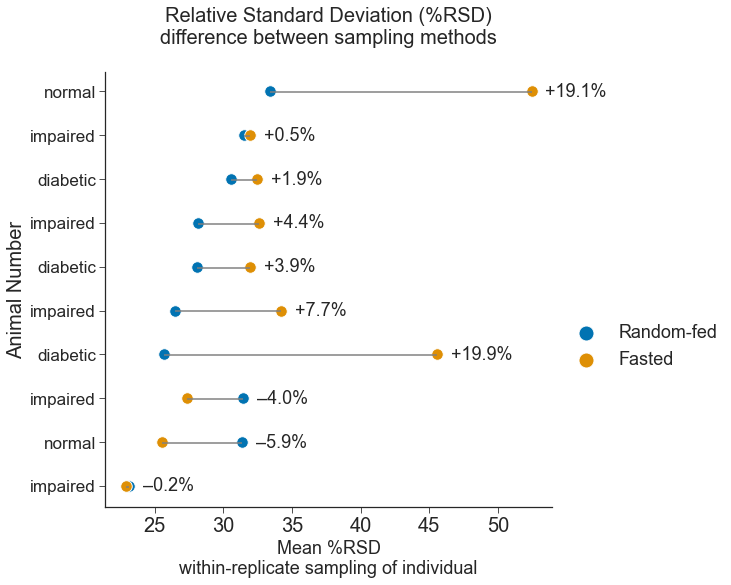

In [107]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

sns.scatterplot(data=result, x='RBG', y='y_index', 
                color=colors['RBG'], 
                s=133,
#                 size='n', sizes=(55, 400),
                label='Random-fed',
                ax=ax)
sns.scatterplot(data=result, x='FBG', y='y_index', 
                color=colors['FBG'], 
                s=133,
#                 size='n', sizes=(55, 400),
                label='Fasted',
                ax=ax)
plt.hlines(y=result['y_index']-0.02, xmin=result['RBG'], xmax=result['FBG'], color='grey', alpha=1)

# add text of difference between
for i, row in result.iterrows():
    plt.annotate(text=row['diff'],
                 xy=(row['max_x'] + 0.99, row['y_index']), 
                 ha='left', va='center', fontsize=18)
# for i, row in result.iterrows():
#     plt.text(x=-0.2, y=row['y_index'], s='n = '+str(row['n']), fontsize=18, ha='right')
# plt.annotate('Lower is better', xy=(5, 15), fontsize=17, ha='right')  # ← 
# plt.text(s='Lower is better', x=5, y=14, fontsize=18, ha='left')

plt.yticks(ticks=result['y_index'], labels=result['gluc_tol'], fontsize=17);
plt.xticks(fontsize=20)
plt.ylabel('Animal Number', fontsize=20)
plt.xlabel('Mean %RSD\nwithin-replicate sampling of individual', fontsize=18)
plt.title('Relative Standard Deviation (%RSD)\ndifference between sampling methods\n', fontsize=20)

# handles, labels = ax.get_legend_handles_labels()
# handles = [handles[0]] + [handles[6]] + handles[1:6]
# labels = [labels[0]] + [labels[6]] + labels[1:6]
plt.legend(
#     handles=handles, labels=labels,
    loc=(1.02, 0.3), markerscale=1.3, fontsize=18)

sns.despine()
# plt.tight_layout()
# plt.savefig(r',,,.png',
#             facecolor='white',
#             dpi=300,
#             bbox_inches='tight')
# plt.savefig(r',,,.svg',
#             facecolor='white',
#             dpi=300,
#             bbox_inches='tight')

# Violin plot
## back-to-back violin plots, horizontal orientation

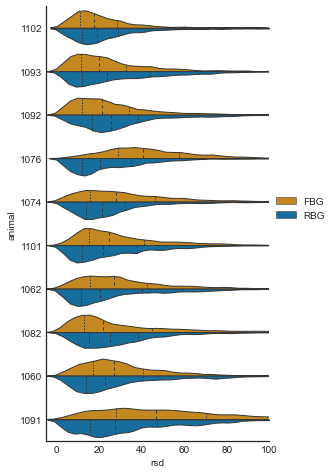

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(4, 8)

sns.violinplot(
    data=vp_result, x='rsd', y='animal', 
    bw=0.1,
#     cut=1, 
    gridsize=50,
    order=result.index, linewidth=1,
    inner='quart',
    hue='bg_type',
    split=True,
    orient='h',
    palette=colors,
    ax=ax,
)

plt.xlim(-5, 100)
# plt.grid()
plt.legend(loc=(1.01, 0.5))

sns.despine()

# Combine plots

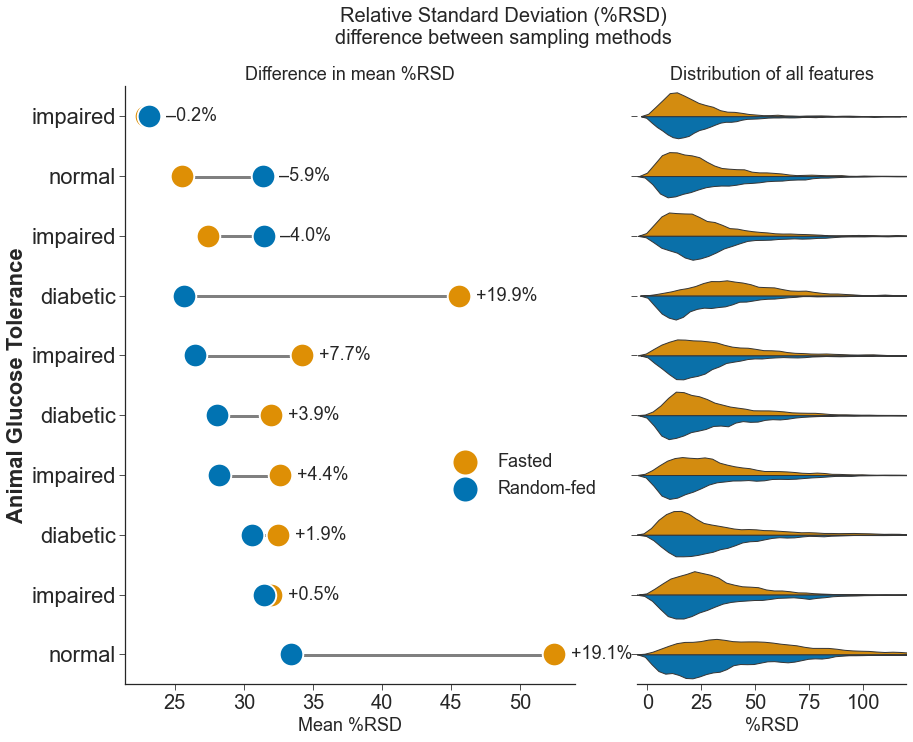

In [108]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, 
                               gridspec_kw={'width_ratios': [2, 1.2], 'wspace': 0.172})
fig.set_size_inches(14, 11)

sns.scatterplot(data=result, x='FBG', y='y_index', 
                color=colors['FBG'], 
                s=555,
#                 size='n', sizes=(55, 400),
                label='Fasted', zorder=3,
                ax=ax1)
sns.scatterplot(data=result, x='RBG', y='y_index', 
                color=colors['RBG'], 
                s=555,
#                 size='n', sizes=(55, 400),
                label='Random-fed', zorder=5,
                ax=ax1)
ax1.hlines(y=result['y_index']+0.01, xmin=result['RBG'], xmax=result['FBG'], 
           color='grey', alpha=1, zorder=0, linewidth=3,)

for i, row in result.iterrows():
    ax1.annotate(text=row['diff'],
                 xy=(row['max_x'] + 1.2, row['y_index']), 
                 ha='left', va='center', fontsize=18)
# ax1.text(s='Lower is better', x=25, y=1, fontsize=18, ha='left')

# handles, labels = ax.get_legend_handles_labels()
# handles = [handles[0]] + [handles[6]] + handles[1:6]
# labels = [labels[0]] + [labels[6]] + labels[1:6]
ax1.legend(
#     handles=handles, labels=labels,
    loc=(0.7, 0.3), markerscale=1.1, fontsize=18)

sns.violinplot(
    data=vp_result, x='rsd', y='animal', 
    bw=0.1, gridsize=50,
    order=result.index, linewidth=1, inner=None,
    hue='bg_type', split=True, orient='h',
    palette=colors, saturation=0.9, legend=False,
    ax=ax2,
)
ax1.set_yticks(ticks=result['y_index'], labels=result['gluc_tol'], fontsize=22)
ax1_xticks = ax1.get_xticks()[1:-1]
ax1.set_xticks(ax1_xticks, ax1_xticks.astype('int'), fontsize=20)
ax1.set_ylabel('Animal Glucose Tolerance', fontsize=22, fontweight='bold')
ax1.set_xlabel('Mean %RSD', fontsize=18)  # \nwithin-replicate sampling of individual
ax1.set_title('Difference in mean %RSD', fontsize=18)

ax2.set_ylabel('')
ax2.set_xlim(-5, 120)
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticks().astype('int'), fontsize=20)
ax2.set_xticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100], fontsize=20)
ax2.set_xlabel('%RSD', fontsize=18)
ax2.set_title('Distribution of all features', fontsize=18)
ax2.get_legend().remove()

# fig.supxlabel('Calculated on repeated measurement of individual')
fig.suptitle('Relative Standard Deviation (%RSD)\ndifference between sampling methods\n', fontsize=20)
sns.despine(ax=ax1)
sns.despine(ax=ax2, left=True)
plt.savefig(r'../reports/figures/4-4-1/mean_RSD_diff.png',
            facecolor='white',
            dpi=300,
            bbox_inches='tight')
plt.savefig(r'../reports/figures/4-4-1/mean_RSD_diff.svg',
            facecolor='white',
            dpi=300,
            bbox_inches='tight')

## Variance plot for Yunyun's method comparison 

In [94]:
data = pd.read_csv(r'D:/Yunyun_method_dev/data/processed/compound_with class for Ben_20220713.csv', index_col=0)
area_cols = data.filter(regex='Group_Area')

groups = {
    **{col: 'butanol' for col in area_cols.filter(regex='Butanol').columns},
    **{col: 'MAW' for col in area_cols.filter(regex='MAW').columns},
    **{col: 'MM500' for col in area_cols.filter(regex='ModMat500_').columns},
    **{col: 'MM500BB' for col in area_cols.filter(regex='ModMat500BB').columns},
    **{col: 'Original' for col in area_cols.filter(regex='Original').columns},
    **{col: 'QC' for col in area_cols.filter(regex='_QC_')}
}
# groups

In [78]:
df = (data
    .loc[data['Checked'] == True, data.columns.isin(area_cols.columns.to_list() + ['super_class'])]
    .groupby(['super_class'])
    .agg('mean')
    .T
#     .insert(loc=0, column='method', value=area_cols.columns.map(groups))
       )
# df = np.log2(df)
df['method'] = df.index.map(groups)
df = df.melt(value_vars=df.columns[:-1], id_vars='method')
log2 = df.copy()
log2['value'] = np.log2(log2['value'])
df

,method,super_class,value
0,butanol,Acyl carnitines,9.170717e+07
1,butanol,Acyl carnitines,8.742044e+07
2,butanol,Acyl carnitines,4.451356e+07
3,MAW,Acyl carnitines,6.789830e+07
4,MAW,Acyl carnitines,7.815528e+07
...,...,...,...
171,Original,Others,7.682694e+07
172,QC,Others,1.130811e+08
173,QC,Others,1.111685e+08
174,QC,Others,1.044122e+08


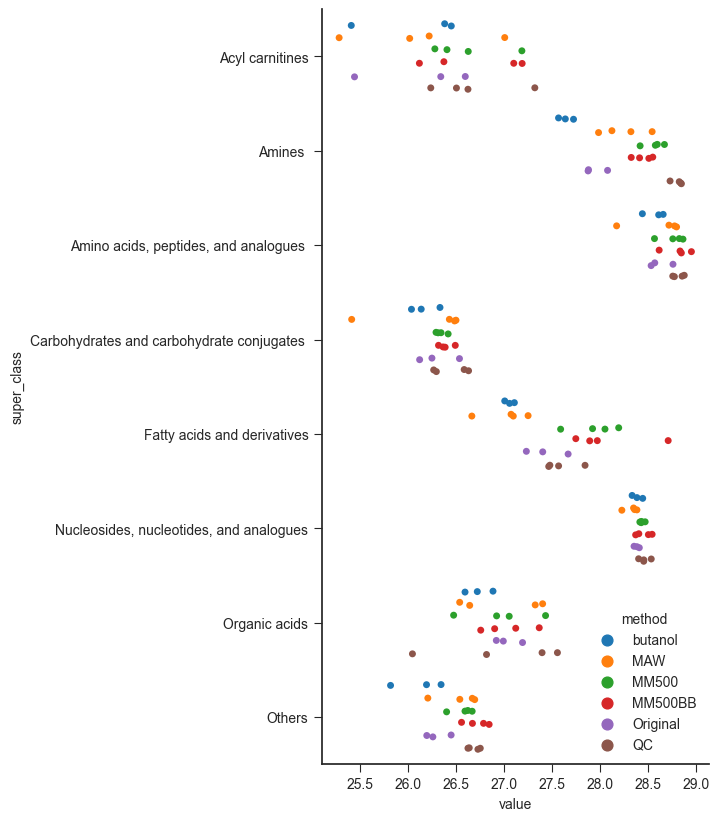

In [80]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=100, facecolor='white')
sns.stripplot(
    data=log2, x='value', y='super_class', hue='method', ax=ax, #orient='h',
    dodge=True, 
#     jitter=False,
)
sns.despine()

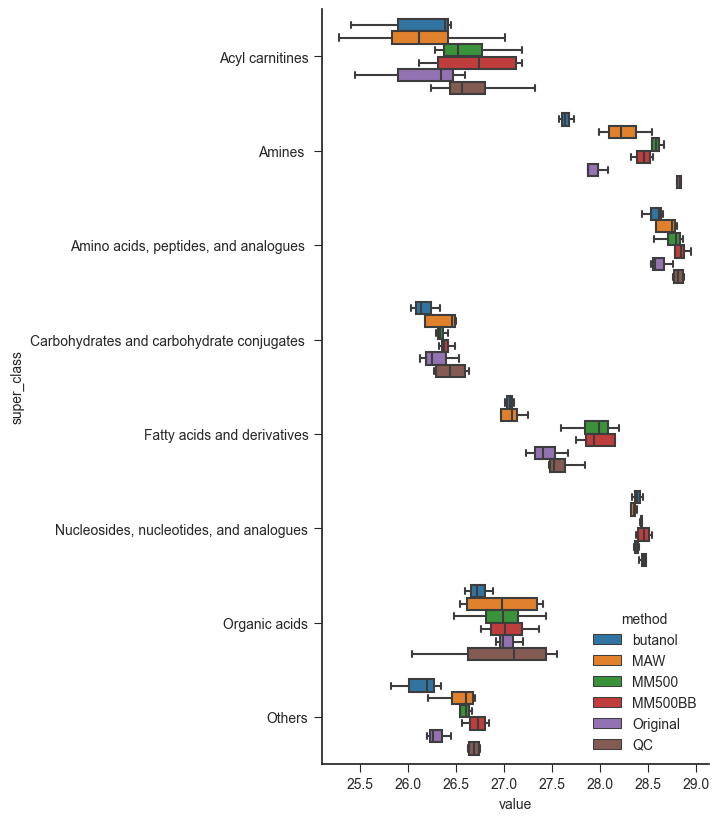

In [72]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=100, facecolor='white')
sns.boxplot(
    data=log2, x='value', y='super_class', hue='method', ax=ax, #orient='h',
    dodge=True, 
#     jitter=False,
    showfliers=False,
)
sns.despine()

In [85]:
rsd = (df
    .groupby(['method', 'super_class'])
    .agg(lambda x: x.mean() / x.std())
    .reset_index()
      )
rsd

,method,super_class,value
0,MAW,Acyl carnitines,2.031097
1,MAW,Amines,5.858556
2,MAW,"Amino acids, peptides, and analogues",5.392148
3,MAW,Carbohydrates and carbohydrate conjugates,3.333620
4,MAW,Fatty acids and derivatives,6.132451
5,MAW,"Nucleosides, nucleotides, and analogues",20.992120
6,MAW,Organic acids,3.285495
7,MAW,Others,6.827756
8,MM500,Acyl carnitines,3.327159
9,MM500,Amines,13.807622


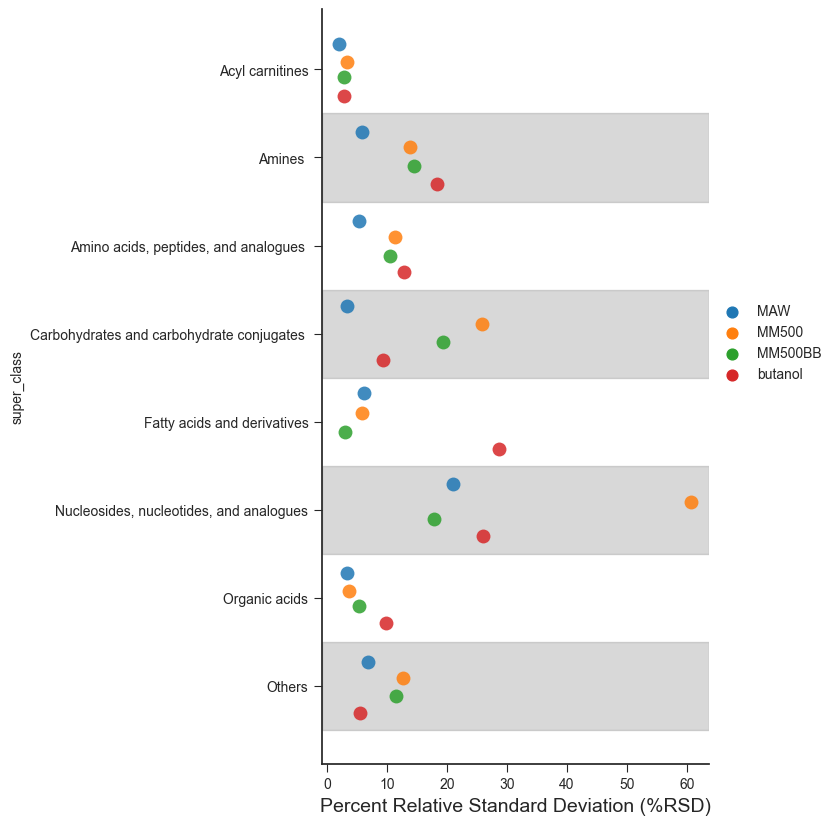

In [92]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=100, facecolor='white')
sns.stripplot(
    data=rsd.loc[~rsd['method'].isin(['Original', 'QC'])], 
    x='value', y='super_class', hue='method', ax=ax,
    dodge=True, size=10, alpha=0.85
)
for i, superclass in enumerate(rsd['super_class'].unique()):
    if i % 2 == 1:
        ax.axhspan(i-0.5, i+0.5, color='gray', alpha=0.3, zorder=-10)
plt.xlabel('Percent Relative Standard Deviation (%RSD)', fontsize=14)
plt.legend(loc=(1.01, 0.5))
sns.despine()

In [3]:
# Standardize data
# data.loc[:, data_cols] = StandardScaler().fit_transform(data.loc[:, data_cols])
# data.loc[:, data_cols]

# Make file grouping 
hmfg = fg[['animal', 'bg_type']].T
# Make another file grouping
hmfg2 = fg[['animal', 'bg_type', 'gluc_tol']].drop_duplicates().set_index(['bg_type', 'animal'])

d = data.loc[:, data_cols].append(hmfg).T
d = d.groupby(['bg_type', 'animal']).mean()
d = d.join(hmfg2)

# Set metadata as indexes
d.set_index('gluc_tol', append=True, inplace=True)
d.sort_values(['bg_type', 'gluc_tol', 'animal'], ascending=[True, False, True], inplace=True)
# d = d.T
d

l_0        l_1        l_2        l_3  \
bg_type animal gluc_tol                                               
FBG     1091   normal    23.670564  24.426323  23.814945  27.047760   
        1093   normal    23.349007  24.616548  23.379382  26.856975   
        1060   impaired  23.449521  24.831670  23.744392  26.953347   
        1062   impaired  23.216855  24.421992  23.356738  26.891357   
        1074   impaired  23.018708  24.185953  23.780521  27.171006   
        1092   impaired  23.101794  24.529641  23.353036  26.837090   
        1102   impaired  23.397215  24.717923  23.763796  26.669624   
        1076   diabetic  22.679690  23.594023  23.103339  26.243724   
        1082   diabetic  23.431994  24.821577  24.038831  27.055425   
        1101   diabetic  23.154617  24.622188  23.729049  26.855539   
RBG     1091   normal    23.966487  24.912942  23.413989  27.350338   
        1093   normal    23.611918  24.567604  23.952991  26.970232   
        1060   impaired  23.840615  25.054730  24.048209  26.942758   
        1062   impaired  23.174288  23.608273  23.749417  27.198735   
        1074   impaired  23.841427  24.962976  24.020401  27.329256   
        1092   impaired  23.792566  24.777115  23.895966  26.998344   
        1102   impaired  23.327583  23.821103  23.528009  26.981334   
        1076   diabetic  23.734863  24.378175  24.449786  27.084315   
        1082   diabetic  23.484084  24.385322  23.706616  27.033307   
        1101   diabetic  23.527161  24.712632  23.719033  27.351148   

                               l_4        l_5        l_6        l_7  \
bg_type animal gluc_tol                                               
FBG     1091   normal    22.170247  26.436732  30.424704  22.466074   
        1093   normal    22.533255  26.449655  29.886286  22.344402   
        1060   impaired  23.045461  26.772249  30.242452  22.307307   
        1062   impaired  22.580229  26.094048  30.027633  22.107637   
        1074   impaired  22.422509  26.311464  30.149799  22.358722   
        1092   impaired  22.474257  26.422284  29.803868  22.168762   
        1102   impaired  22.677837  26.558844  30.213943  21.652245   
        1076   diabetic  21.424737  25.785970  29.826501  21.363046   
        1082   diabetic  22.366938  26.500553  30.194233  22.469145   
        1101   diabetic  22.692777  26.635056  29.893134  22.022698   
RBG     1091   normal    22.522382  26.369622  30.082804  22.245460   
        1093   normal    22.766641  26.289131  29.724295  22.193878   
        1060   impaired  23.111682  26.549709  30.545997  22.049367   
        1062   impaired  22.836285  25.802277  30.074647  22.321493   
        1074   impaired  23.168719  26.720635  30.201864  22.192797   
        1092   impaired  22.327510  26.536968  30.031506  22.095893   
        1102   impaired  22.490114  26.265088  29.628747  22.088169   
        1076   diabetic  23.238189  26.765223  30.220139  22.219264   
        1082   diabetic  22.766074  26.174567  29.874454  21.999458   
        1101   diabetic  22.704753  26.508672  29.912160  22.483285   

                               l_8        l_9  ...      m_682      m_368  \
bg_type animal gluc_tol                        ...                         
FBG     1091   normal    26.377794  24.326876  ...  20.577814  23.013146   
        1093   normal    25.825897  23.655871  ...  20.256022  22.662139   
        1060   impaired  26.009478  23.951241  ...  20.042547  22.365933   
        1062   impaired  25.893946  23.497447  ...  19.709896  22.319930   
        1074   impaired  26.064572  23.761601  ...  20.633094  22.845992   
        1092   impaired  25.718736  23.434220  ...  20.025014  22.484600   
        1102   impaired  26.003035  23.460890  ...  20.249462  22.592770   
        1076   diabetic  25.680440  22.886061  ...  19.429659  22.204800   
        1082   diabetic  26.126511  23.991184  ...  20.208397  22.441951   
        1101   diabetic  25.784276  23.702454  ...  20.014211  22.569

In [4]:
data.loc[data['fdr corrected pval effect of sampling'] < 0.000000000000000001].index

Index(['l_65', 'l_88', 'l_213', 'l_218', 'l_223', 'l_237', 'l_283', 'l_285',
       'l_291', 'l_293', 'l_372', 'l_375', 'l_382', 'l_383', 'l_425', 'l_427',
       'l_430', 'l_431', 'l_462', 'l_648', 'l_649', 'l_657', 'l_669', 'l_680',
       'l_681', 'l_734', 'l_751', 'l_822', 'l_1027', 'm_349', 'm_673', 'm_303',
       'm_9', 'm_519', 'm_460', 'm_70'],
      dtype='object', name='i')

## Perform Wilcoxon signed rank test on the 10 pairs of distributions, put asterisks next to significant pairs

In [12]:
pairs = {animal: {'RBG': None, 'FBG': None} for animal in animals_used}

for bg_type, pos_index, bg_color in zip(['FBG', 'RBG'], [0, 1], [colors['FBG'], colors['RBG']]):
    for animal, position in zip(animals_used, positions):
        files = fg.loc[(fg['animal'] == animal) & (fg['bg_type'] == bg_type)].index
        df = data.loc[:, files]#.mean(axis=1)
        df = (df.std(axis=1)/df.mean(axis=1)) * 100
        pairs[animal][bg_type] = df
        
wilcoxon_test = {}
for animal, dfs in pairs.items():
    rbg = dfs['RBG']
    fbg = dfs['FBG']
    wilcoxon_test[animal] = wilcoxon(rbg, fbg)[1]
wilcoxon_test

{1091: 7.261296575751756e-47,
 1093: 7.429715870297852e-10,
 1060: 0.24527022757086647,
 1062: 7.022679845989094e-17,
 1074: 4.668867845568178e-33,
 1092: 2.4431757335185137e-15,
 1102: 0.6663749502965913,
 1076: 4.4062427014813735e-158,
 1082: 0.00029890243625575,
 1101: 4.3292217738676625e-23}

[(0.0, 1.0), (2.5, 3.5), (5.0, 6.0), (7.5, 8.5), (10.0, 11.0), (12.5, 13.5), (15.0, 16.0), (17.5, 18.5), (20.0, 21.0), (22.5, 23.5)]


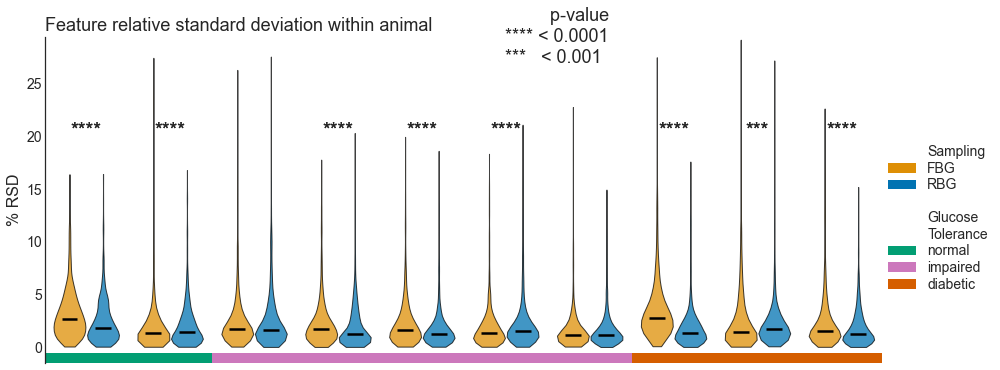

In [37]:
signif_sampling = data.loc[data['fdr corrected pval effect of sampling'] < 2].index

# fig, (ax, axcbar) = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [5, 1]})
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
# plt.xlim(-1, 29)
# plt.ylim(0.0, 0.7)
# positions = [(0,1), (2.5,3.5), (5,6), (7.5,8.5), (10,11), (12.5,13.5), (15,16), (17.5,18.5), (20,21), (22.5,23.5)]
x = (0, 1)
positions = [(x[0] + offset, x[1] + offset) for offset in np.arange(0, 25, 2.5)]
print(positions)
# ax.set_xticks([np.mean(x) for x in positions])
# ax.set_xticklabels([str(animal) + '\n' + animal_gluc_tol[animal] for animal in animals_used], fontsize=16)

for bg_type, pos_index, bg_color in zip(['FBG', 'RBG'], [0, 1], [colors['FBG'], colors['RBG']]):
    for animal, position in zip(animals_used, positions):
        files = fg.loc[(fg['animal'] == animal) & (fg['bg_type'] == bg_type)].index
        df = data.loc[signif_sampling, files]#.mean(axis=1)
        df = (df.std(axis=1)/df.mean(axis=1)) * 100
#         df = df.std(axis=1)/df.mean(axis=1)
        v = plt.violinplot(
            df, 
            positions=[position[pos_index]],
            widths=0.95,
            points=45,
            showmeans=False,
            showextrema=False,
            showmedians=True,
#             quantiles=[0, 0.9],
#             handle=(('Fasted' if bg_type == 'FBG' else 'Random-fed') if animal==1102 else None)
        )
#         for bodies, cmeans, cmaxes, cmins, cbars, cquantiles in v:
        for part in v['bodies']:
            part.set_facecolor(bg_color)
            part.set_edgecolor('black')
            part.set_alpha(0.75)
        animal_color = colors[str(animal)]
        for line in [
#             'cmaxes', 
#             'cbars', 
#             'cmins', 
            'cmedians',
#             'cmeans', 
#             'cquantiles',
             ]:
#             v[line].set_color(animal_color)
            v[line].set_color('black')
            v[line].set_linewidths(2.5)
        # print significance asterisks
        if wilcoxon_test[animal] < 0.0001:
            ax.annotate('****', xy=(position[0]+0.5, 20), fontsize=20, ha='center')
        elif wilcoxon_test[animal] < 0.001:
            ax.annotate('***', xy=(position[0]+0.5, 20), fontsize=20, ha='center')
        elif wilcoxon_test[animal] < 0.01:
            ax.annotate('**', xy=(position[0]+0.5, 20), fontsize=25, ha='center')
        elif wilcoxon_test[animal] < 0.05:
            ax.annotate('*', xy=(position[0]+0.5, 20), fontsize=25, ha='center')
        

keys = list(colors.keys())[2:7]
labels = [name for name in keys]
handles = [Patch(facecolor=colors[label]) for label in labels]
legend_categories = ['Sampling', '\nGlucose\nTolerance']
for divider, category in zip([0, 3], legend_categories): 
    handles.insert(divider, Patch(edgecolor='white', facecolor='white', alpha=0))
    labels.insert(divider, category)
ax.legend(handles, labels, loc=(1, 0.2), fontsize=14, labelspacing=0.2)
# ax.legend(handles, ['Fasted', 'Post-prandial'], loc=(1.01, 0.5), fontsize=15)
ax.annotate('         p-value\n**** < 0.0001 \n***   < 0.001', xy=(12.99, 27), fontsize=18, )


ax.margins(x=0.01, y=0.01)
plt.yticks(fontsize=14)
plt.ylabel('% RSD', fontsize=16)
sns.despine(bottom=True)
ax.set_title('Feature relative standard deviation within animal',#      < 0.0001 ****    < 0.001  ***', 
             fontsize=18, loc='left')
# ax.annorate
plt.xticks([], [])

original_xlim = plt.xlim()
dividers = [(positions[1][1] + positions[2][0])/2, (positions[6][1] + positions[7][0])/2]
plt.axvspan(-100,        dividers[0], ymin=0, ymax=0.03, facecolor=colors['normal'],)
plt.axvspan(dividers[0], dividers[1], ymin=0, ymax=0.03, facecolor=colors['impaired'],)
plt.axvspan(dividers[1], 100,         ymin=0, ymax=0.03, facecolor=colors['diabetic'],)
plt.xlim(original_xlim)
plt.ylim(bottom=-1.5)

plt.savefig(r'..\reports\figures\4-4-1\RvF_RSD_per_rat.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\4-4-1\RvF_RSD_per_rat.png', bbox_inches='tight')

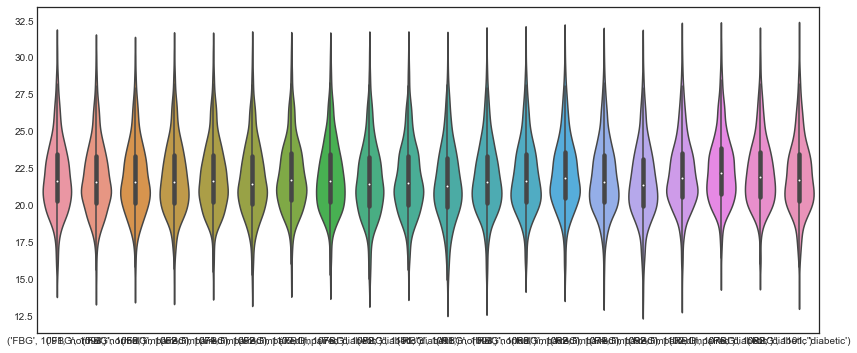

In [10]:
sns.violinplot(data=d.T)

fig = plt.gcf()
fig.set_size_inches((14,6))

In [196]:
for bg_type, pos_index, bg_color in zip(['FBG', 'RBG'], [0, 1], [colors['FBG'], colors['RBG']]):
    for i, (animal, position) in enumerate(zip(animals_used, positions)):
        files = fg.loc[(fg['animal'] == animal) & (fg['bg_type'] == bg_type), 'combined_col_name']
        df = data[files]
        display(df.mean(axis=1)/df.std(axis=1))

i
l_0       43.249393
l_1       18.856541
l_2       57.093581
l_3       75.427518
l_4       29.771018
            ...    
m_169    206.395720
m_213      6.628793
m_24      39.365602
m_505     23.123211
m_441     39.093178
Length: 1727, dtype: float64

i
l_0       72.658342
l_1      110.480202
l_2       72.385376
l_3      106.840731
l_4       30.937176
            ...    
m_169     86.526405
m_213     16.162214
m_24     152.217511
m_505     32.995891
m_441     76.893259
Length: 1727, dtype: float64

i
l_0      132.724216
l_1       41.804300
l_2       57.026350
l_3      105.147759
l_4       54.181066
            ...    
m_169    233.056729
m_213     10.945104
m_24      61.647489
m_505     15.230408
m_441    308.538564
Length: 1727, dtype: float64

i
l_0      153.230007
l_1      152.853347
l_2       65.242174
l_3      121.555784
l_4      113.893948
            ...    
m_169    156.850813
m_213      7.566004
m_24      34.898137
m_505      9.239072
m_441     78.610440
Length: 1727, dtype: float64

i
l_0       29.151818
l_1       14.408948
l_2       66.410721
l_3       58.898398
l_4      135.895823
            ...    
m_169    285.133695
m_213      8.971422
m_24      67.240211
m_505     27.577414
m_441     82.942577
Length: 1727, dtype: float64

i
l_0       41.286390
l_1      129.946832
l_2       46.565178
l_3       32.712137
l_4       46.414428
            ...    
m_169    444.277450
m_213     11.208574
m_24      41.605853
m_505     10.087832
m_441    114.006071
Length: 1727, dtype: float64

i
l_0      115.244131
l_1       85.102590
l_2      246.046557
l_3       76.104449
l_4       72.802138
            ...    
m_169    388.663400
m_213     16.523081
m_24     100.654956
m_505     57.649702
m_441    394.805129
Length: 1727, dtype: float64

i
l_0       11.401856
l_1       11.975119
l_2       10.927934
l_3       16.239688
l_4       11.946358
            ...    
m_169    108.648716
m_213      8.770629
m_24      39.379802
m_505      7.069091
m_441     62.432728
Length: 1727, dtype: float64

i
l_0      151.757207
l_1      209.620600
l_2      256.820933
l_3       77.688854
l_4       45.240340
            ...    
m_169    260.109750
m_213     11.775488
m_24      59.598657
m_505     30.286710
m_441     70.532642
Length: 1727, dtype: float64

i
l_0       33.153305
l_1       74.805498
l_2       80.766211
l_3      107.784112
l_4       60.061386
            ...    
m_169     81.621249
m_213      7.633212
m_24      39.803128
m_505      7.977387
m_441    102.782421
Length: 1727, dtype: float64

i
l_0       71.016891
l_1       33.314304
l_2       16.427123
l_3      989.125528
l_4       21.976604
            ...    
m_169    348.304179
m_213     41.170382
m_24     214.208978
m_505     66.427245
m_441    159.329182
Length: 1727, dtype: float64

i
l_0       30.471409
l_1       35.273934
l_2       77.682163
l_3       37.702654
l_4       41.791372
            ...    
m_169    130.104131
m_213     14.691750
m_24      77.177883
m_505     20.885236
m_441    103.462307
Length: 1727, dtype: float64

i
l_0       34.889069
l_1       39.703885
l_2       27.528672
l_3       31.548779
l_4       28.671377
            ...    
m_169     99.464444
m_213      6.467432
m_24      32.593588
m_505      9.088316
m_441    104.029517
Length: 1727, dtype: float64

i
l_0       32.955849
l_1       19.291759
l_2       54.838319
l_3       97.571622
l_4       43.240101
            ...    
m_169    244.887818
m_213     61.273601
m_24     517.261378
m_505    173.100887
m_441    278.557111
Length: 1727, dtype: float64

i
l_0      122.452665
l_1       79.156169
l_2       43.622106
l_3      221.192874
l_4      115.399633
            ...    
m_169    216.128995
m_213      7.930279
m_24      52.304602
m_505     13.239594
m_441     87.742446
Length: 1727, dtype: float64

i
l_0      155.436570
l_1      134.633546
l_2       62.215988
l_3       59.490710
l_4       29.487881
            ...    
m_169    135.438731
m_213      8.240182
m_24      39.976161
m_505      8.048925
m_441     78.431526
Length: 1727, dtype: float64

i
l_0      229.180064
l_1       17.360256
l_2       77.085594
l_3      101.156898
l_4       34.361264
            ...    
m_169    680.224569
m_213     82.904318
m_24     332.945739
m_505    247.447815
m_441    584.295776
Length: 1727, dtype: float64

i
l_0       69.723981
l_1       43.232924
l_2       83.832582
l_3       54.736336
l_4      101.293809
            ...    
m_169    169.346472
m_213     21.185940
m_24     134.049968
m_505    124.590079
m_441    190.248094
Length: 1727, dtype: float64

i
l_0      131.220325
l_1       39.055490
l_2       23.662213
l_3       36.871800
l_4       30.464412
            ...    
m_169    188.319580
m_213     13.091512
m_24      73.791684
m_505     27.841360
m_441    124.074999
Length: 1727, dtype: float64

i
l_0       56.265075
l_1       82.093668
l_2      119.390881
l_3       52.343033
l_4      142.394321
            ...    
m_169    248.737810
m_213     11.236301
m_24      76.586345
m_505     24.528767
m_441    236.298725
Length: 1727, dtype: float64

KeyError: 'combined_col_name'

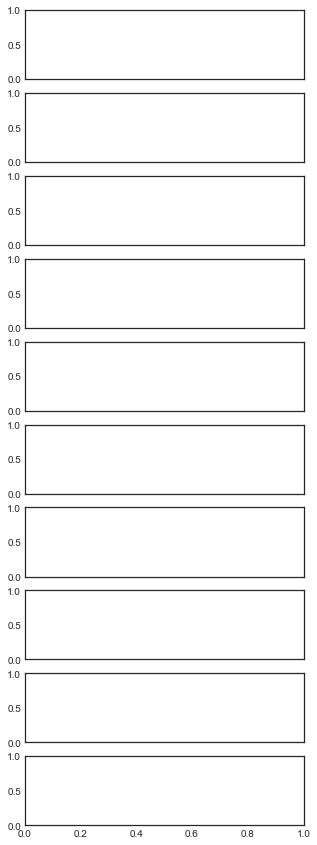

In [7]:
signif_sampling = data.loc[data['fdr corrected pval effect of sampling'] < 0.05].index


fig, axs = plt.subplots(nrows=10, sharex=True, sharey=True)
fig.set_size_inches(5, 15)

for bg_type, pos_index, bg_color in zip(['FBG', 'RBG'], [0, 1], [colors['FBG'], colors['RBG']]):
    for i, (animal, position) in enumerate(zip(animals_used, positions)):
        files = fg.loc[(fg['animal'] == animal) & (fg['bg_type'] == bg_type), 'combined_col_name']
        df = data.loc[signif_sampling, files]#.mean(axis=1)
        df = df.std(axis=1)/df.mean(axis=1)
        ax = axs[i]
        ax.hist(df, bins=40, alpha=0.5, color=bg_color)
        ax.set_yticks([])
        ax.set_xticks([])
sns.despine(left=True, bottom=True)
plt.xlim(0, 0.15)
# plt.tight_layout(pad=1.01)
plt.subplots_adjust(hspace=0.01)

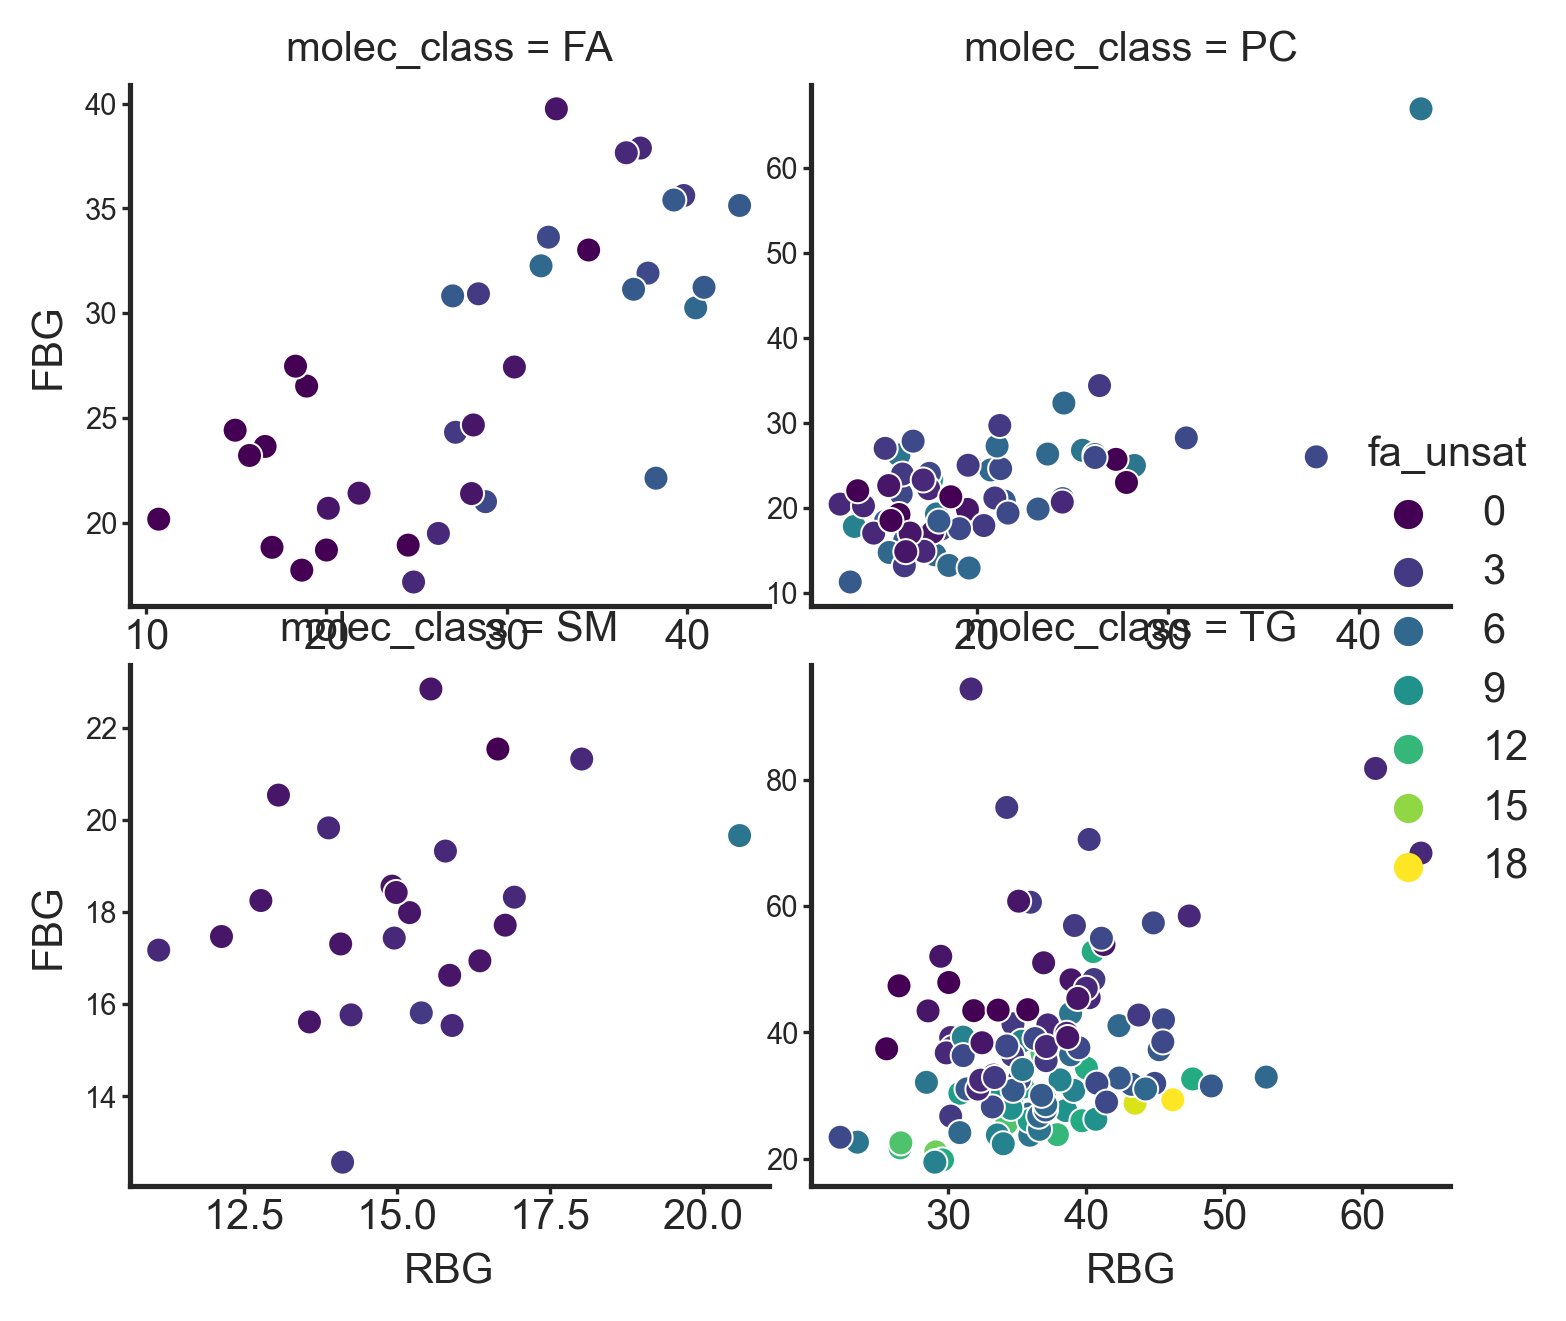

In [135]:
fdf = df.loc[df['molec_class'].isin(['TG', 'PC', 'FA', 'SM'])]
rp = sns.relplot(
    data=fdf, 
    x='RBG', y='FBG', col='molec_class', hue='fa_unsat', palette='viridis',
    col_wrap=2, 
    legend='auto',
    facet_kws=dict(sharex=False, sharey=False, 
#                    gridspec_kws=dict(wspace=0.3, hspace=0.3)
                  ),
)
fig = rp.figure
fig.set_dpi(300)
fig.set_size_inches((5, 4))